In [1]:
# use dream_proj_env conda env
import pandas as pd
import scanpy as sc 
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, kruskal, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
#import gseapy
from pybiomart import Dataset
import sys
import colorcet as cc
import pickle
from sklearn.utils import Bunch
#import omicverse as ov

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)
coolwarm_categorical = plt.cm.get_cmap('coolwarm', 10)

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

organ_palette = {
    "Liver": my_categorical_palette[1],
    "Kidney": my_categorical_palette[2],
    "Brain": my_categorical_palette[5],
}

dream_col = 'DREAM_normalized_enrichment_score_resid'
mut_col = 'mutation_count_per_kb_top50expr'

/Users/zanekoch/Documents/dream_test/dream_proj/dream_proj_env3_uv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zanekoch/Documents/dream_test/dream_proj/dream_proj_env3_uv/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/var/folders/z_/fkp32h052nb7sr17w1jn8txw0000gn/T/ipykernel_28653/3799100730.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_cat

In [2]:
import os
# repo root for relative paths
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

In [2]:
sns.set_context("paper")
sns.set_style("white")
# add axes tickmarks
sns.set_style("ticks")

# Read data

In [3]:
loader = read_data.DatasetLoader("TMS")
tms = loader.load_dataset()

Loading dataset: TMS


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zanekoch/Documents/dream_test/dream_proj/data/tabula_muris_senis/tms_old_geneset.pkl'

# Example DREAM activity heatmap and calculation 

Text(6.944444444444445, 0.5, 'Cells')

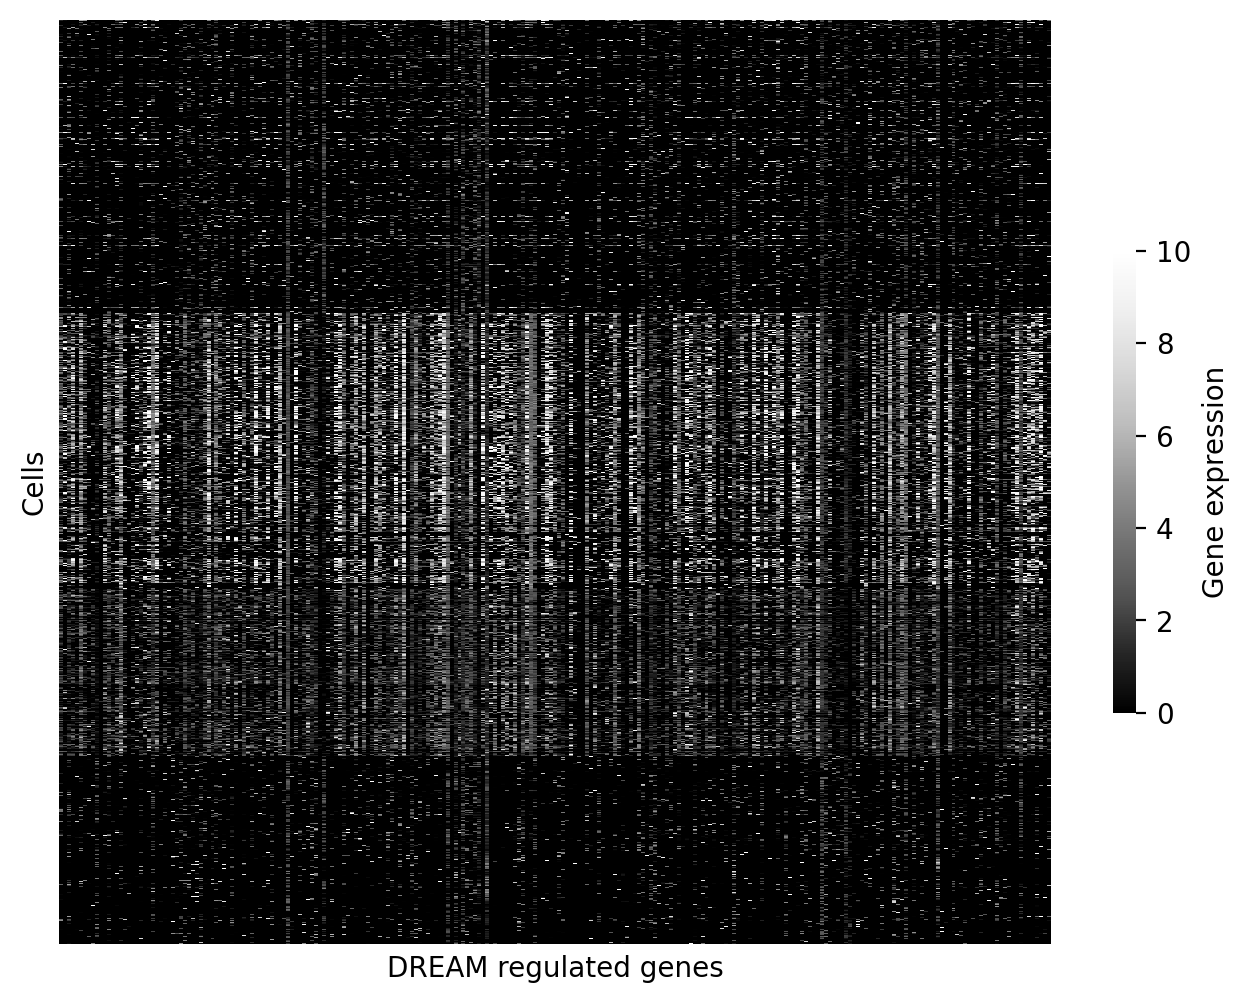

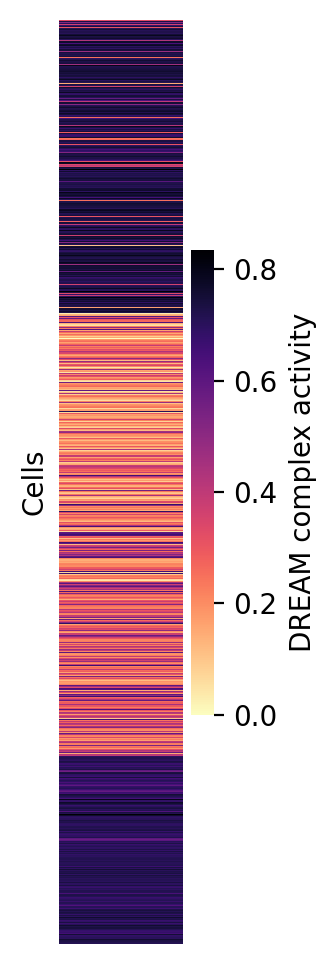

In [7]:
cts = ['CD4-positive, alpha-beta T cell', 'macrophage', 'granulocyte monocyte progenitor cell', 'late pro-B cell']
sorted_cells = tms.adata.obs.query("tissue == 'Marrow' and cell_type in @cts").sort_values('cell_type', ascending=False).index
sorted_cell_types = tms.adata.obs.query("tissue == 'Marrow' and cell_type in @cts").sort_values('cell_type', ascending=False).cell_type
sorted_cell_expr = tms.adata[sorted_cells.values, tms.dream_regulated_genes_w_expression].to_df()

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# add box around the heatmap
sns.heatmap(sorted_cell_expr, xticklabels=False, yticklabels=False, cmap='Greys_r',
            #label cbar and shrink
            cbar_kws={'label': 'Gene expression', 'shrink': 0.5}, ax=axes, rasterized=True)
plt.xlabel('DREAM regulated genes')
plt.ylabel('Cells')
# save as svg
# change font type to none

plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/dream_expression_heatmap_pt1.svg'), format='svg', dpi=300)

fig, axes = plt.subplots(1, 1, figsize=(1, 6))
sns.heatmap(tms.dream_expression[sorted_cells.values,:].obs[dream_col].to_frame(), xticklabels=False, yticklabels=False, cmap='magma_r',
            #label cbar
            cbar_kws={'label': 'DREAM complex activity'}, rasterized=True,
            ax=axes)
plt.ylabel('Cells')
plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/dream_expression_heatmap_pt2.svg'), format='svg', dpi=300)

Text(6.933333333333329, 0.5, 'Cells')

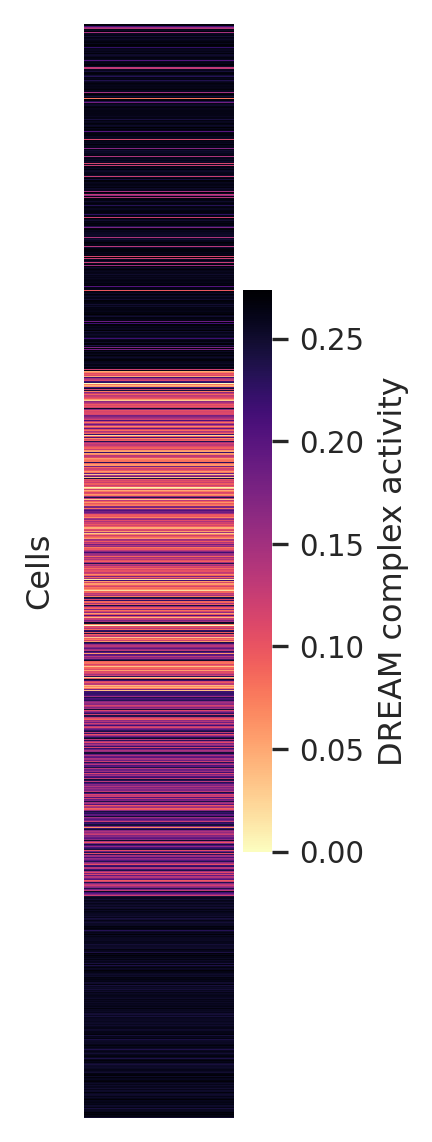

In [91]:
cts = ['CD4-positive, alpha-beta T cell', 'macrophage', 'granulocyte monocyte progenitor cell', 'late pro-B cell']
sorted_cells = tms.adata.obs.query("tissue == 'Marrow' and cell_type in @cts").sort_values('cell_type', ascending=False).index
sorted_cell_types = tms.adata.obs.query("tissue == 'Marrow' and cell_type in @cts").sort_values('cell_type', ascending=False).cell_type
sorted_cell_expr = tms_new.adata[sorted_cells.values, tms.dream_regulated_genes_w_expression].to_df()





fig, axes = plt.subplots(1, 1, figsize=(1, 6))
sns.heatmap(tms.dream_expression[sorted_cells.values,:].obs['DREAM_regulated_genes_aucell'].to_frame(), xticklabels=False, yticklabels=False, cmap='magma_r',
            #label cbar
            cbar_kws={'label': 'DREAM complex activity'}, rasterized=True,
            ax=axes)
plt.ylabel('Cells')

# Mutation burden by tissue and age

/tmp/ipykernel_2637408/1021651316.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burden_order = copy.groupby(['tissue', 'age_months'])[mut_col].quantile(0.75).sort_values(ascending=False).reset_index().query('age_months == 24')['tissue']


Diaphragm SignificanceResult(statistic=np.float64(0.46404659409657045), pvalue=np.float64(1.519400671593342e-99))
Kidney SignificanceResult(statistic=np.float64(0.45683582006638784), pvalue=np.float64(3.4812820288021725e-95))
BAT SignificanceResult(statistic=np.float64(0.014393907496811362), pvalue=np.float64(0.4979643087994525))
Spleen SignificanceResult(statistic=np.float64(0.7259390033854847), pvalue=np.float64(0.0))
Limb Muscle SignificanceResult(statistic=np.float64(0.3467920613750473), pvalue=np.float64(2.3027927280253864e-109))
Large Intestine SignificanceResult(statistic=np.float64(0.4742801208789492), pvalue=np.float64(0.0))
Aorta SignificanceResult(statistic=np.float64(0.29091079603158876), pvalue=np.float64(3.952109921367752e-19))
MAT SignificanceResult(statistic=np.float64(0.3768044798322862), pvalue=np.float64(4.616886620595474e-101))
Trachea SignificanceResult(statistic=np.float64(0.41605646628787313), pvalue=np.float64(3.505666310294088e-130))
GAT SignificanceResult(stat

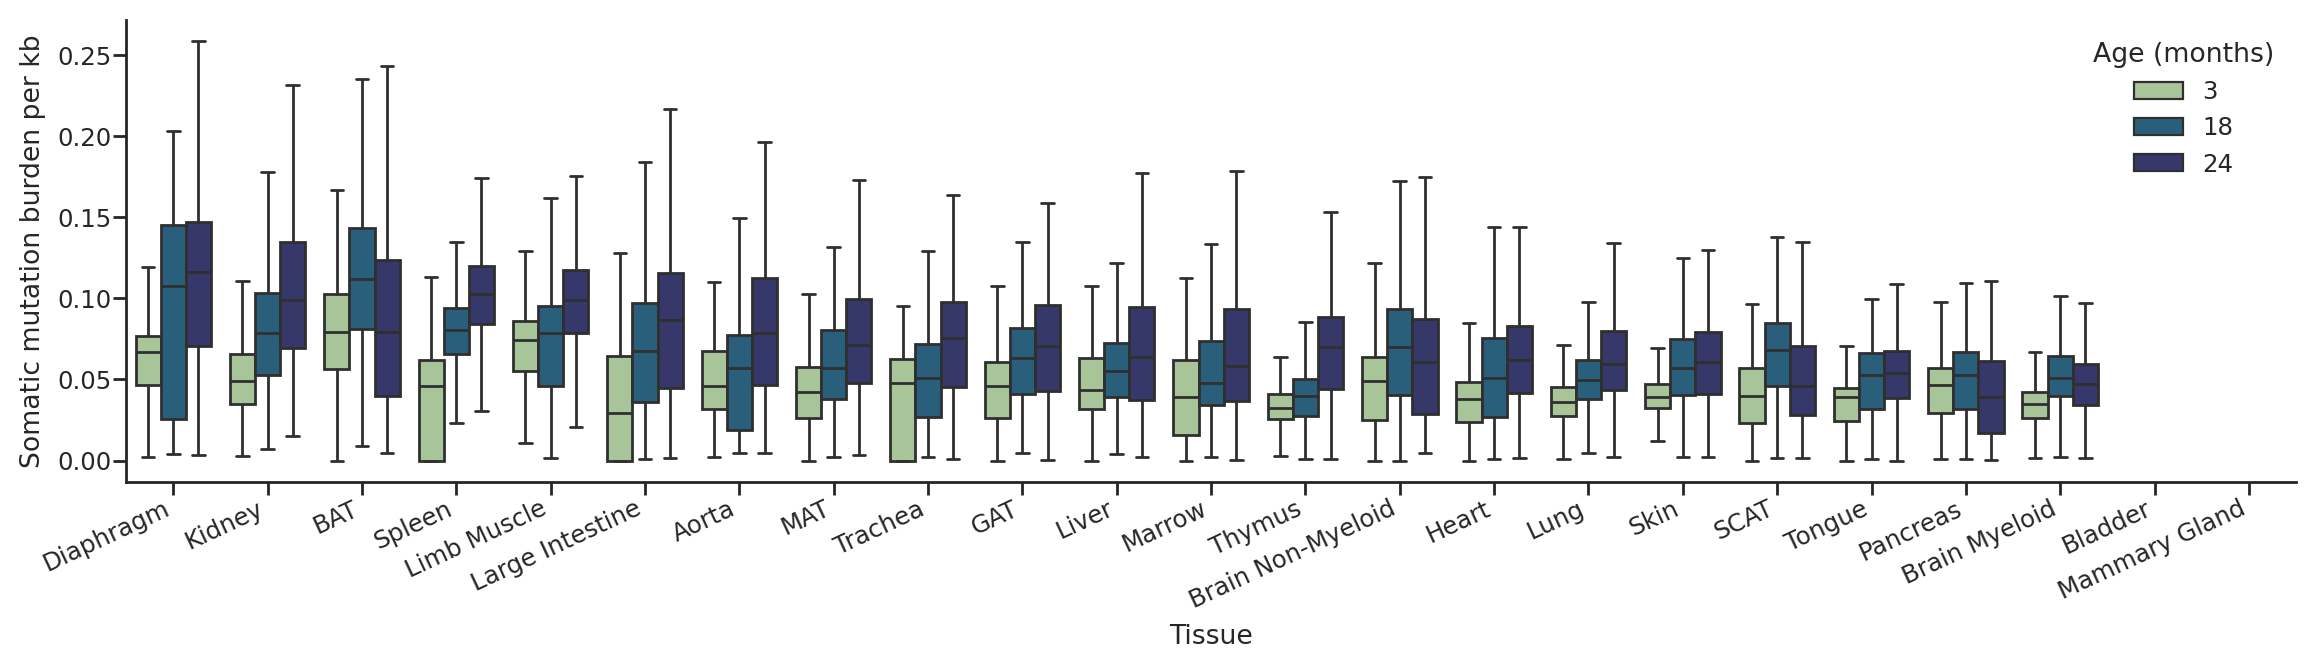

In [21]:
copy = tms.dream_expression.obs.query("age_months != 21 and tissue != 'Mammary Gland' and tissue != 'Bladder'").copy()
fig, axes = plt.subplots(figsize=(14,3))
# within each age, bin the mean_dream_activity into 3 bins
burden_order = copy.groupby(['tissue', 'age_months'])[mut_col].quantile(0.75).sort_values(ascending=False).reset_index().query('age_months == 24')['tissue']
sns.boxplot(
    data = copy, y = mut_col, x = 'tissue',
    hue = 'age_months', palette='crest', showfliers = False,
    ax = axes, order = burden_order, hue_order=[3, 18, 24]
    )
# angle x labels
axes.tick_params(pad=.5)
_ = plt.xticks(rotation=25, ha='right')
plt.xlabel('Tissue')
plt.ylabel('Somatic mutation burden per kb')
# remove legend border
plt.legend(title='Age (months)', frameon=False)
sns.despine()
#plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/mutation_burden_by_tissue_age_box.svg'), format='svg', dpi=300)
for tissue in burden_order:
    print(tissue, spearmanr(copy.dropna(subset=['age_months', mut_col]).loc[copy['tissue'] == tissue, 'age_months'], copy.dropna(subset=['age_months', mut_col]).loc[copy['tissue'] == tissue, mut_col]))


# DREAM activity vs. mutation rate

/tmp/ipykernel_894540/3774416914.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = tms.dream_expression.obs.query("age_months != 21 and tissue != 'Mammary Gland'").groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(
/tmp/ipykernel_894540/3774416914.py:12: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


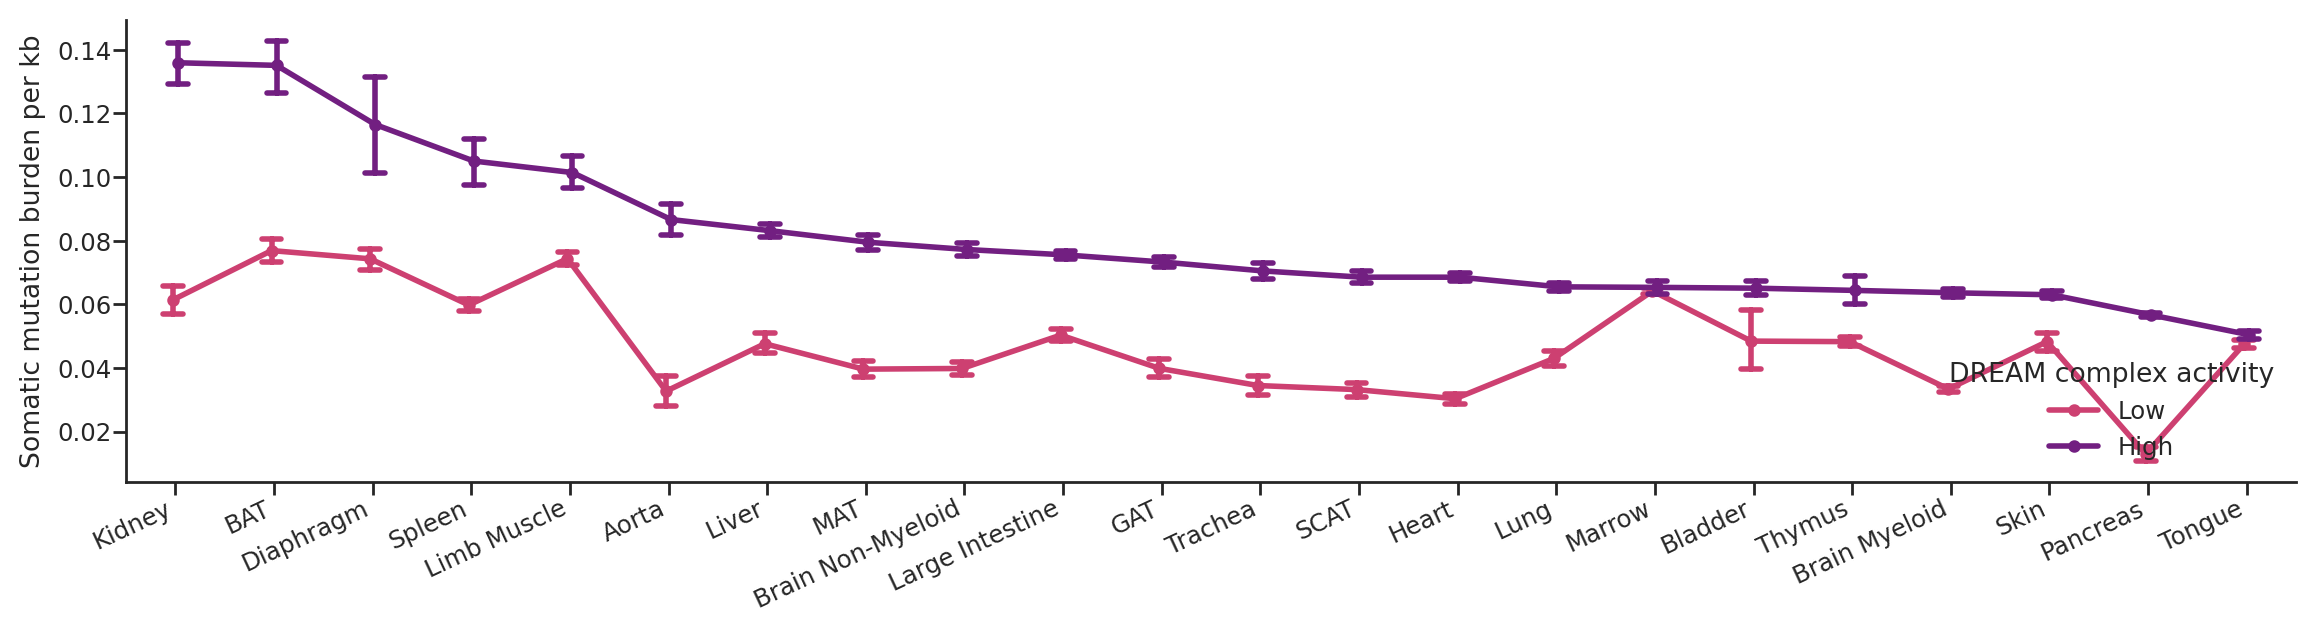

Skin MannwhitneyuResult(statistic=np.float64(375383.5), pvalue=np.float64(1.3883919765513372e-26))
Pancreas MannwhitneyuResult(statistic=np.float64(419773.5), pvalue=np.float64(6.446580113279826e-109))
Limb Muscle MannwhitneyuResult(statistic=np.float64(180249.0), pvalue=np.float64(1.9173952583291388e-17))
Heart MannwhitneyuResult(statistic=np.float64(1671577.0), pvalue=np.float64(4.819253516319307e-186))
Spleen MannwhitneyuResult(statistic=np.float64(77638.5), pvalue=np.float64(7.844105764069467e-19))
Diaphragm MannwhitneyuResult(statistic=np.float64(32243.5), pvalue=np.float64(1.1912774101996432e-07))
Trachea MannwhitneyuResult(statistic=np.float64(202396.0), pvalue=np.float64(3.879294394164522e-46))
Tongue MannwhitneyuResult(statistic=np.float64(721709.5), pvalue=np.float64(0.00019917946921355615))
Thymus MannwhitneyuResult(statistic=np.float64(142887.0), pvalue=np.float64(1.8827828154494333e-11))
Brain Non-Myeloid MannwhitneyuResult(statistic=np.float64(879819.5), pvalue=np.float64

In [4]:
fig, axes = plt.subplots(figsize=(14,3))

# within each age, bin the mean_dream_activity into 3 bins
tms.dream_expression.obs['dream_activity_bin'] = tms.dream_expression.obs.groupby(['age_months'])[dream_col].transform(
    lambda x: pd.qcut(x, 5, labels = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']))

order = tms.dream_expression.obs.query("age_months != 21 and tissue != 'Mammary Gland'").groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(
    ascending=False
    ).reset_index().query("dream_activity_bin == 'High'")['tissue']
# remove mammary gland samples
order = order[order != 'Mammary Gland']
sns.pointplot(
    data = tms.dream_expression.obs, y = mut_col, x = 'tissue',
    hue = 'dream_activity_bin', # showfliers = False,
    hue_order=['Low', 'High'], palette=[magma_categorical(5), magma_categorical(3)],
    ax = axes, order = order, errorbar = 'ci', join=True, dodge=True, capsize=.2, 
    # make lines thinner
    linewidth = 2, markersize = 3, rasterized=True,
    
    )
# angle x labels
_ = plt.xticks(rotation=25, ha='right')
axes.tick_params(pad=.5)
plt.xlabel('')
plt.ylabel('Somatic mutation burden per kb')
plt.legend(title='DREAM complex activity', frameon=False, loc='lower right')
# move y axis to the right
sns.despine()
# output to svg
#plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/mutation_burden_by_tissue_dream_activity_horizontal.svg'), format='svg', dpi=300)
plt.show()

# for each tissue, test if the distribution of mutations in high dream is different than low dream
for tissue in tms.dream_expression.obs['tissue'].unique():
    print(tissue,
        mannwhitneyu(
            tms.dream_expression.obs.query('tissue == @tissue and dream_activity_bin == "High"').dropna()[mut_col],
            tms.dream_expression.obs.query('tissue == @tissue and dream_activity_bin == "Low"').dropna()[mut_col]
        )
    )

In [7]:
(tms.dream_expression.obs.query("age_months == 18  and tissue.isin(@order) and dream_activity_bin == 'High'").groupby('tissue')[mut_col].mean() / tms.dream_expression.obs.query("age_months == 18  and tissue.isin(@order) and dream_activity_bin == 'Low'").groupby('tissue')[mut_col].mean()).describe()

/tmp/ipykernel_894540/4037064848.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (tms.dream_expression.obs.query("age_months == 18  and tissue.isin(@order) and dream_activity_bin == 'High'").groupby('tissue')[mut_col].mean() / tms.dream_expression.obs.query("age_months == 18  and tissue.isin(@order) and dream_activity_bin == 'Low'").groupby('tissue')[mut_col].mean()).describe()
/tmp/ipykernel_894540/4037064848.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (tms.dream_expression.obs.query("age_months == 18  and tissue.isin(@order) and dream_activity_bin == 'High'").groupby('tissue')[mut_col].mean() / 

count    22.000000
mean      1.971147
std       0.825864
min       0.983710
25%       1.489462
50%       1.707807
75%       2.225414
max       4.705694
Name: mutation_count_per_kb_top50expr, dtype: float64

In [56]:
0.132951/0.056506

2.3528651824585003

In [58]:
tms.dream_expression.obs.query("age_months == 18 and age_months != 21 and tissue == 'Kidney'").groupby('dream_activity_bin')[mut_col].count()

/tmp/ipykernel_66769/216536783.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tms.dream_expression.obs.query("age_months == 18 and age_months != 21 and tissue == 'Kidney'").groupby('dream_activity_bin')[mut_col].count()


dream_activity_bin
Low             90
Low-Medium     188
Medium         163
Medium-High    137
High            90
Name: mutation_count_per_kb_top50expr, dtype: int64

/tmp/ipykernel_2381000/2119837581.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = tms.dream_expression.obs.query("age_months == 3 and age_months != 21 and tissue != 'Mammary Gland' and tissue != 'Bladder'").groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(
/tmp/ipykernel_2381000/2119837581.py:12: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


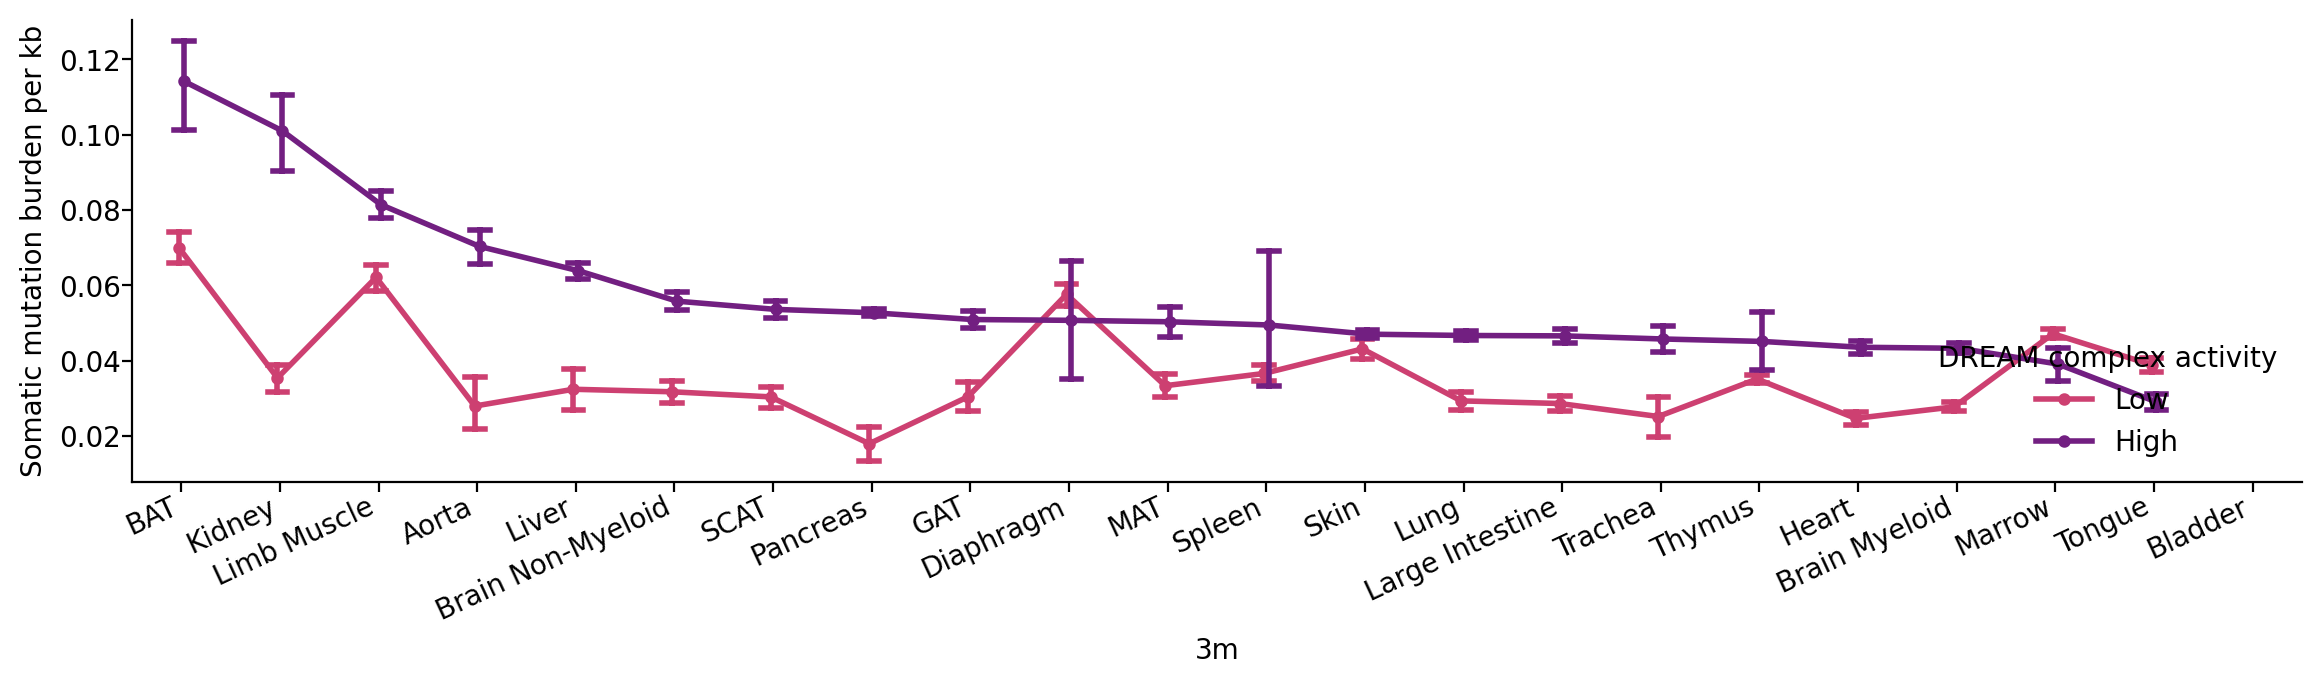

Skin MannwhitneyuResult(statistic=375383.5, pvalue=1.3883919765513372e-26)
Pancreas MannwhitneyuResult(statistic=419773.5, pvalue=6.446580113279826e-109)
Limb Muscle MannwhitneyuResult(statistic=180249.0, pvalue=1.9173952583291388e-17)
Heart MannwhitneyuResult(statistic=1671577.0, pvalue=4.819253516319307e-186)
Spleen MannwhitneyuResult(statistic=77638.5, pvalue=7.844105764069467e-19)
Diaphragm MannwhitneyuResult(statistic=32243.5, pvalue=1.1912774101996432e-07)
Trachea MannwhitneyuResult(statistic=202396.0, pvalue=3.879294394164522e-46)
Tongue MannwhitneyuResult(statistic=721709.5, pvalue=0.00019917946921355615)
Thymus MannwhitneyuResult(statistic=142887.0, pvalue=1.8827828154494333e-11)
Brain Non-Myeloid MannwhitneyuResult(statistic=879819.5, pvalue=7.494442306949374e-102)
Brain Myeloid MannwhitneyuResult(statistic=1006595.0, pvalue=3.393652032675172e-195)
Bladder MannwhitneyuResult(statistic=48880.5, pvalue=0.004825639711031849)
Large Intestine MannwhitneyuResult(statistic=4533676.0

In [20]:
fig, axes = plt.subplots(figsize=(14,3))

# within each age, bin the mean_dream_activity into 3 bins
tms.dream_expression.obs['dream_activity_bin'] = tms.dream_expression.obs.groupby(['age_months'])[dream_col].transform(
    lambda x: pd.qcut(x, 5, labels = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']))

order = tms.dream_expression.obs.query("age_months == 3 and age_months != 21 and tissue != 'Mammary Gland' and tissue != 'Bladder'").groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(
    ascending=False
    ).reset_index().query("dream_activity_bin == 'High'")['tissue']
# remove mammary gland samples
order = order[order != 'Mammary Gland']
sns.pointplot(
    data = tms.dream_expression.obs.query("age_months == 3 and age_months != 21 and tissue != 'Mammary Gland'  and tissue != 'Bladder'"), y = mut_col, x = 'tissue',
    hue = 'dream_activity_bin', # showfliers = False,
    hue_order=['Low', 'High'], palette=[magma_categorical(5), magma_categorical(3)],
    ax = axes, order = order, errorbar = 'ci', join=True, dodge=True, capsize=.2, 
    # make lines thinner
    linewidth = 2, markersize = 3, rasterized=True,
    
    )
# angle x labels
_ = plt.xticks(rotation=25, ha='right')
axes.tick_params(pad=.5)
plt.xlabel('3m')
plt.ylabel('Somatic mutation burden per kb')
plt.legend(title='DREAM complex activity', frameon=False, loc='lower right')
# move y axis to the right
sns.despine()
# output to svg
plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/mutation_burden_by_tissue_dream_activity_horizontal_3m.svg'), format='svg', dpi=300)
plt.show()

# for each tissue, test if the distribution of mutations in high dream is different than low dream
for tissue in tms.dream_expression.obs['tissue'].unique():
    print(tissue,
        mannwhitneyu(
            tms.dream_expression.obs.query('tissue == @tissue and dream_activity_bin == "High"').dropna()[mut_col],
            tms.dream_expression.obs.query('tissue == @tissue and dream_activity_bin == "Low"').dropna()[mut_col]
        )
    )

# Umaps of tissue, DREAM, and mutation burden

In [ ]:
# just to get the order, within each age, bin the mean_dream_activity into 3 bins 
tms.dream_expression.obs['dream_activity_bin'] = tms.dream_expression.obs.groupby(['age_months'])[dream_col].transform(
    lambda x: pd.qcut(x, 5, labels = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']))
order = tms.dream_expression.obs.groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(
    ascending=False
    ).reset_index().query("dream_activity_bin == 'High'")['tissue']

tissues_to_plot = order[:12]
# subset anndata to only include these tissues
adata_to_plot = tms.dream_expression[tms.dream_expression.obs['tissue'].isin(tissues_to_plot)]
sc._settings.settings._vector_friendly=True

with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (1000)}):
    sc.pl.umap(
        adata_to_plot, 
        color = ['cell_type'],
        show=True,
        save = os.path.join(REPO_ROOT, 'figures/fig1/UMAP_cell_types.svg'),palette=cc.glasbey_warm,
        add_outline = False,frameon=False,
        # remove legend
        legend_loc = None,
        )


In [ ]:
magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)

# bin dream activity and mutation count within each tissue
tms.dream_expression.obs['mean_dream_activity_q'] = tms.dream_expression.obs.groupby(['age_months', 'tissue'])[dream_col].transform(
    lambda x: pd.qcut(x, 2, labels = ['Lowest 50%', 'Highest 50%'])
    )
tms.dream_expression.obs['mutation_count_q'] = tms.dream_expression.obs.groupby(['age_months', 'tissue'])[mut_col].transform(
    lambda x: pd.qcut(x, 2, labels = ['Lowest 50%', 'Highest 50%'])
    )

tms.dream_expression.obs['mean_dream_activity_q'] = tms.dream_expression.obs['mean_dream_activity_q'].str.split('_').str[0]
tms.dream_expression.obs['mutation_count_q'] = tms.dream_expression.obs['mutation_count_q'].str.split('_').str[0]

tissues_to_plot = order[:12]
# subset anndata to only include these tissues
adata_to_plot = tms.dream_expression[tms.dream_expression.obs['tissue'].isin(tissues_to_plot)]
sc._settings.settings._vector_friendly=True


with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (1000)}):

    sc.pl.umap(
        adata_to_plot, 
        color = ['mutation_count_q'],
        show=True, #palette = 'coolwarm',
        palette=['magenta','mediumseagreen' ],
        save =  os.path.join(REPO_ROOT, 'figures/fig1/umapUMAP_dreamVmut2.svg'),
        #palette=['silver', magma_categorical(4), 'teal' ]
        )


In [ ]:
with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (1000)}):
    sc.pl.umap(
        adata_to_plot, 
        color = ['mean_dream_activity_q'],
        show = True, #palette = 'coolwarm',
        # 20-40, 40-60, 60-80, highest, lowest
        save = os.path.join(REPO_ROOT, 'figures/fig1/umapUMAP_dreamVmut1.svg'),
        palette=[magma_categorical(2), magma_categorical(6)]
        )

# hepatocyte example

MannwhitneyuResult(statistic=127419389.5, pvalue=1.0889828706289461e-210)
SignificanceResult(statistic=0.158572022668626, pvalue=1.1857605082245002e-243)
MannwhitneyuResult(statistic=89190807.5, pvalue=0.0)
SignificanceResult(statistic=0.3021127224934178, pvalue=0.0)
MannwhitneyuResult(statistic=69750770.0, pvalue=2.1658954434463177e-268)
SignificanceResult(statistic=0.2050793943548307, pvalue=1.5219209755427153e-294)


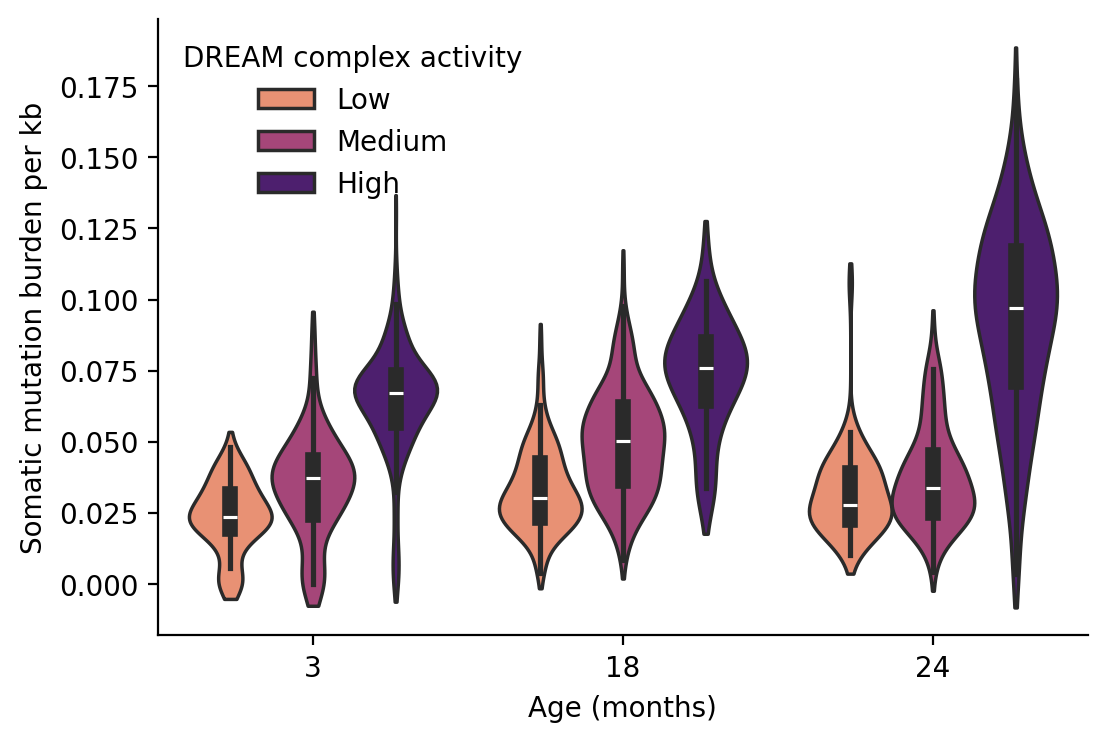

In [80]:
# within each age, bin the mean_dream_activity into 3 bins
fig, axes  = plt.subplots(figsize=(6,4))
tms.dream_expression.obs['dream_activity_bin'] = tms.dream_expression.obs.groupby('age_months')[dream_col].transform(
    lambda x: pd.qcut(x, 3, labels = ['Low', 'Medium', 'High'])
    )

sns.violinplot(
    data = tms.dream_expression.obs.query("cell_type == 'hepatocyte'"), y = mut_col, x = 'age_months',
    hue = 'dream_activity_bin', palette='magma_r', dodge=True, 
    cut = 1, hue_order=['Low', 'Medium', 'High'],
    order = ['3', '18', '24'],# dodge=True, #showfliers = False,
    ax = axes, density_norm="width", common_norm=True,
    )
axes.set_xlabel('Age (months)')
plt.ylabel('Somatic mutation burden per kb')
plt.legend(title='DREAM complex activity', frameon=False)
sns.despine()
# output
#plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/mutation_burden_by_age_dream_activity_violin.svg'), format='svg', dpi=300)

# test for significance between each dream_activity_bin group within each age
print(mannwhitneyu(tms.dream_expression.obs.query("age_months == 3 and dream_activity_bin == 'High'")[mut_col].dropna(), tms.dream_expression.obs.query("age_months == 3 and dream_activity_bin == 'Low'")[mut_col].dropna()))
print(spearmanr(tms.dream_expression.obs.query("age_months == 3")[dream_col], tms.dream_expression.obs.query("age_months == 3")[mut_col],  nan_policy='omit'))
print(mannwhitneyu(tms.dream_expression.obs.query("age_months == 18 and dream_activity_bin == 'High'")[mut_col].dropna(), tms.dream_expression.obs.query("age_months == 18 and dream_activity_bin == 'Low'")[mut_col].dropna()))
print(spearmanr(tms.dream_expression.obs.query("age_months == 18")[dream_col], tms.dream_expression.obs.query("age_months == 18")[mut_col],  nan_policy='omit'))
print(mannwhitneyu(tms.dream_expression.obs.query("age_months == 24 and dream_activity_bin == 'High'")[mut_col].dropna(), tms.dream_expression.obs.query("age_months == 24 and dream_activity_bin == 'Low'")[mut_col].dropna()))
print(spearmanr(tms.dream_expression.obs.query("age_months == 24")[dream_col], tms.dream_expression.obs.query("age_months == 24")[mut_col],  nan_policy='omit'))

# Association within cell types

In [ ]:
#facs.obs.query("age_months != '21m'", inplace=True)

effect_within_cell_and_age = tms.dream_expression.obs.groupby(['cell_type'])[
    [dream_col, mut_col]
    ].corr(method = 'spearman').reset_index().iloc[::2]
effect_within_cell_and_age.drop([dream_col, 'level_2'], axis=1, inplace=True)
effect_within_cell_and_age.rename(columns={mut_col:r'Spearman $\rho$'}, inplace=True)
effect_within_cell_and_age.query("age_months != 21", inplace=True)

# pivot effect_within_cell_and_age to have cell_type as index and age as columns
effect_within_cell_and_age_pivot = effect_within_cell_and_age.pivot(
    index='cell_type', columns='age_months', values=r'Spearman $\rho$'
    )
# drop infrequent cell types
cell_types = tms.dream_expression.obs['cell_type'].value_counts()
freq_cell_types = cell_types[cell_types > 100].index
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[freq_cell_types, :]
# order rows by mean coff 3m, 18m, and 24m
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[
    effect_within_cell_and_age_pivot.mean(axis=1).sort_values(ascending=False).index
    ]

fig, axes = plt.subplots(figsize=(6,4))
sns.kdeplot(
    data = effect_within_cell_and_age, x = r'Spearman $\rho$', hue = 'age_months', fill=True, palette='crest',  common_norm = True, clip = (-1,1), ax = axes
    )
axes.set_xlabel('Spearman correlation of DREAM complex\nactivity and mutation count')
sns.despine()
#plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/correlation_btwn_dream_and_mut_celltype_kde.svg'), format='svg', dpi=300)
# remove box and background from legend and move to left
axes.legend_.set_frame_on(False)
axes.legend_.set_title('Age (months)')


/tmp/ipykernel_3337504/595166062.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  effect_within_cell_and_age = tms.dream_expression.obs.groupby(['cell_type', 'age_months'])[


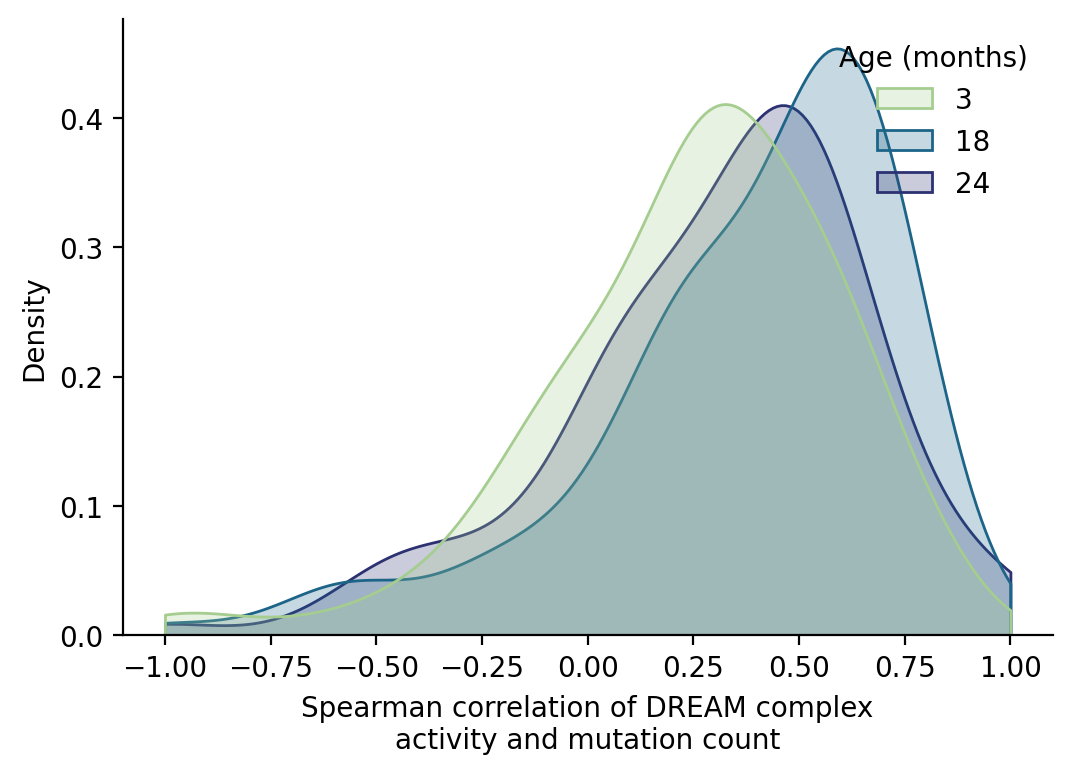

In [139]:
#facs.obs.query("age_months != '21m'", inplace=True)

effect_within_cell_and_age = tms.dream_expression.obs.groupby(['cell_type', 'age_months'])[
    [dream_col, mut_col]
    ].corr(method = 'spearman').reset_index().iloc[::2]
effect_within_cell_and_age.drop([dream_col, 'level_2'], axis=1, inplace=True)
effect_within_cell_and_age.rename(columns={mut_col:r'Spearman $\rho$'}, inplace=True)
effect_within_cell_and_age.query("age_months != 21", inplace=True)

# pivot effect_within_cell_and_age to have cell_type as index and age as columns
effect_within_cell_and_age_pivot = effect_within_cell_and_age.pivot(
    index='cell_type', columns='age_months', values=r'Spearman $\rho$'
    )
# drop infrequent cell types
cell_types = tms.dream_expression.obs['cell_type'].value_counts()
freq_cell_types = cell_types[cell_types > 100].index
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[freq_cell_types, :]
# order rows by mean coff 3m, 18m, and 24m
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[
    effect_within_cell_and_age_pivot.mean(axis=1).sort_values(ascending=False).index
    ]

fig, axes = plt.subplots(figsize=(6,4))
sns.kdeplot(
    data = effect_within_cell_and_age, x = r'Spearman $\rho$', hue = 'age_months', fill=True, palette='crest',  common_norm = True, clip = (-1,1), ax = axes
    )
axes.set_xlabel('Spearman correlation of DREAM complex\nactivity and mutation count')
sns.despine()
plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/correlation_btwn_dream_and_mut_celltype_kde.svg'), format='svg', dpi=300)
# remove box and background from legend and move to left
axes.legend_.set_frame_on(False)
axes.legend_.set_title('Age (months)')


/tmp/ipykernel_3337504/3171114399.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_df = resid_df.groupby(['cell_type', 'age_months'])[


<Axes: xlabel='mutation_count_per_kb_top50expr', ylabel='Density'>

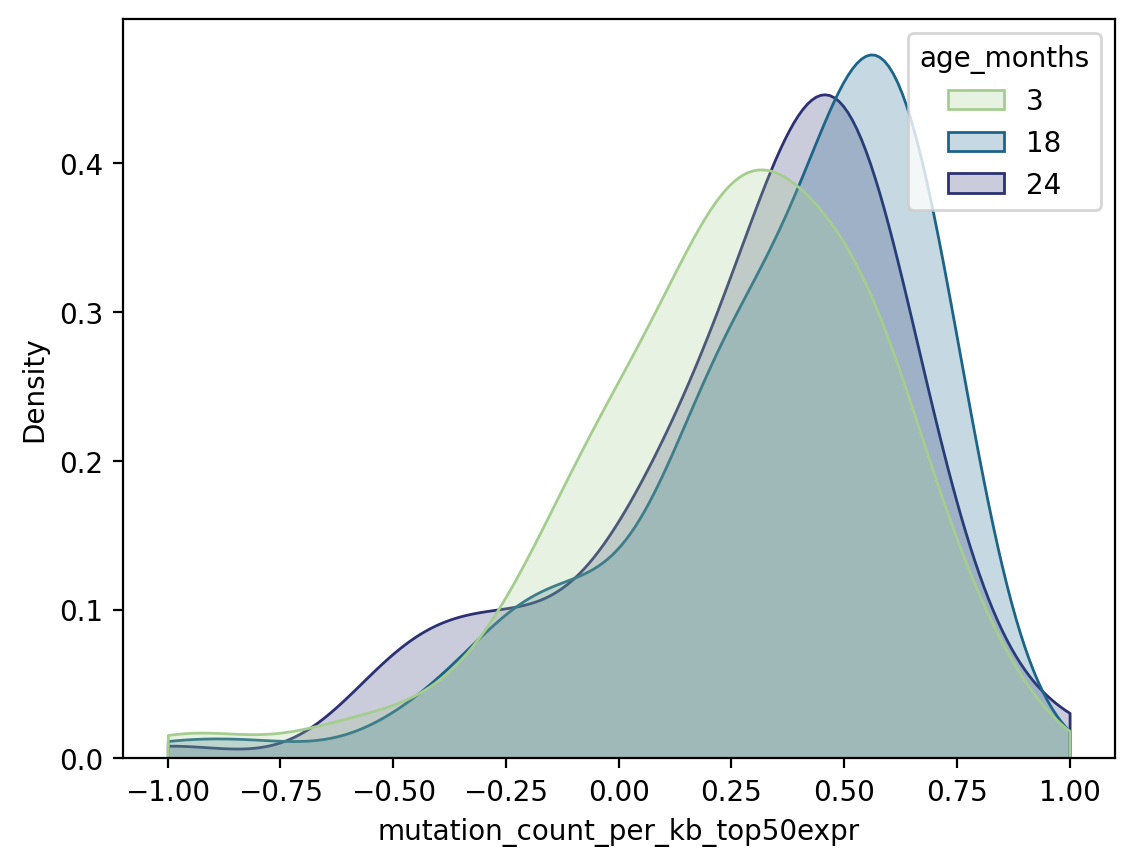

In [138]:
# marginal association correcting for cell_type
mut_explained_by_n_counts = smf.ols(
    f'{mut_col} ~ n_counts * cell_type ',
    data = tms.dream_expression.obs.query("age_months != 21").dropna(subset=[dream_col, mut_col])
    ).fit()

dream_explained_by_n_counts = smf.ols(
    f'{dream_col} ~ n_counts * cell_type ',
    data = tms.dream_expression.obs.query("age_months != 21").dropna(subset=[dream_col, mut_col])
    ).fit()
resid_df = pd.DataFrame({
    'tissue': tms.dream_expression.obs.query("age_months != 21").dropna(subset=[dream_col, mut_col])['tissue'],
    'cell_type': tms.dream_expression.obs.query("age_months != 21").dropna(subset=[dream_col, mut_col])['cell_type'],
    'age_months': tms.dream_expression.obs.query("age_months != 21").dropna(subset=[dream_col, mut_col])['age_months'],
    'mutation_count_per_kb_top50expr': mut_explained_by_n_counts.resid,
    'DREAM_normalized_enrichment_score_resid': dream_explained_by_n_counts.resid
    })
corr_df = resid_df.groupby(['cell_type', 'age_months'])[
    [dream_col, mut_col]
    ].corr(method = 'spearman').reset_index().iloc[::2]
sns.kdeplot(
    data = corr_df, x = mut_col, hue = 'age_months', fill=True, palette='crest',  common_norm = True, clip = (-1,1)
    )

# negative control backgroun

In [3]:
# read in files from slurm jobs

output_dir = os.path.join(REPO_ROOT, "notebooks/assorted_outputs/TMS_random_background")
# read in each parquet file and combine into one df
files = [f for f in os.listdir(output_dir) if f.endswith('cells.parquet')]
dfs = []
for f in files:
    dfs.append(pd.read_parquet(os.path.join(output_dir, f)))
# concat    
random_background = pd.concat(dfs, axis=0)

output_dir = os.path.join(REPO_ROOT, "notebooks/assorted_outputs/TMS_random_background")
files = [f for f in os.listdir(output_dir) if f.endswith('cells_noregress.parquet')]
dfs = []
for f in files:
    dfs.append(pd.read_parquet(os.path.join(output_dir, f)))
random_background_noregress = pd.concat(dfs, axis=0)

### Within tissue types

In [4]:
# calculate correlation dfs
raw_corr_df2 = random_background.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )[mut_col].reset_index()
raw_corr_df2.rename(columns={'level_2':'variable', mut_col:'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df2['is_random_background'] = raw_corr_df2["variable"].str.contains('random')
raw_corr_df2.query("variable.str.contains('random') or variable == @dream_col", inplace=True)

corr_df = tms.dream_expression.obs.groupby(['tissue', 'age_months'])[
    [mut_col, dream_col]
    ].corr(method = 'spearman').reset_index().iloc[::2]
corr_df.rename(columns={'level_2':'variable',dream_col:'Spearmanr'}, inplace=True)
corr_df['is_random_background'] = False
raw_corr_df2.query("variable != 'DREAM_normalized_enrichment_score_resid'", inplace=True)
random_background_corr_df_tissue = pd.concat([raw_corr_df2, corr_df])

/tmp/ipykernel_66769/3820375578.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_df = tms.dream_expression.obs.groupby(['tissue', 'age_months'])[


In [5]:
# calculate correlation dfs
raw_corr_df_no_regress = random_background_noregress.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )[mut_col].reset_index()
raw_corr_df_no_regress.rename(columns={'level_2':'variable', mut_col:'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df_no_regress['is_random_background'] = raw_corr_df_no_regress["variable"].str.contains('random')
raw_corr_df_no_regress.query(
    "variable.str.contains('random')", 
    inplace=True
    )

corr_no_regress_df = tms.dream_expression.obs.groupby(['tissue', 'age_months'])[
    [mut_col, 'DREAM_normalized_enrichment_score']
    ].corr(method = 'spearman').reset_index().iloc[::2]
corr_no_regress_df.rename(
    columns={'level_2':'variable','DREAM_normalized_enrichment_score':'Spearmanr'}, inplace=True
    )
# flip the sign of DREAM_normalized_enrichment_score spearmans, to make direction consistent
corr_no_regress_df['Spearmanr'] = -corr_no_regress_df['Spearmanr']
corr_no_regress_df['is_random_background'] = False
random_background_no_regress_corr_df_tissue = pd.concat([raw_corr_df_no_regress, corr_no_regress_df])


/tmp/ipykernel_66769/4251761250.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_no_regress_df = tms.dream_expression.obs.groupby(['tissue', 'age_months'])[


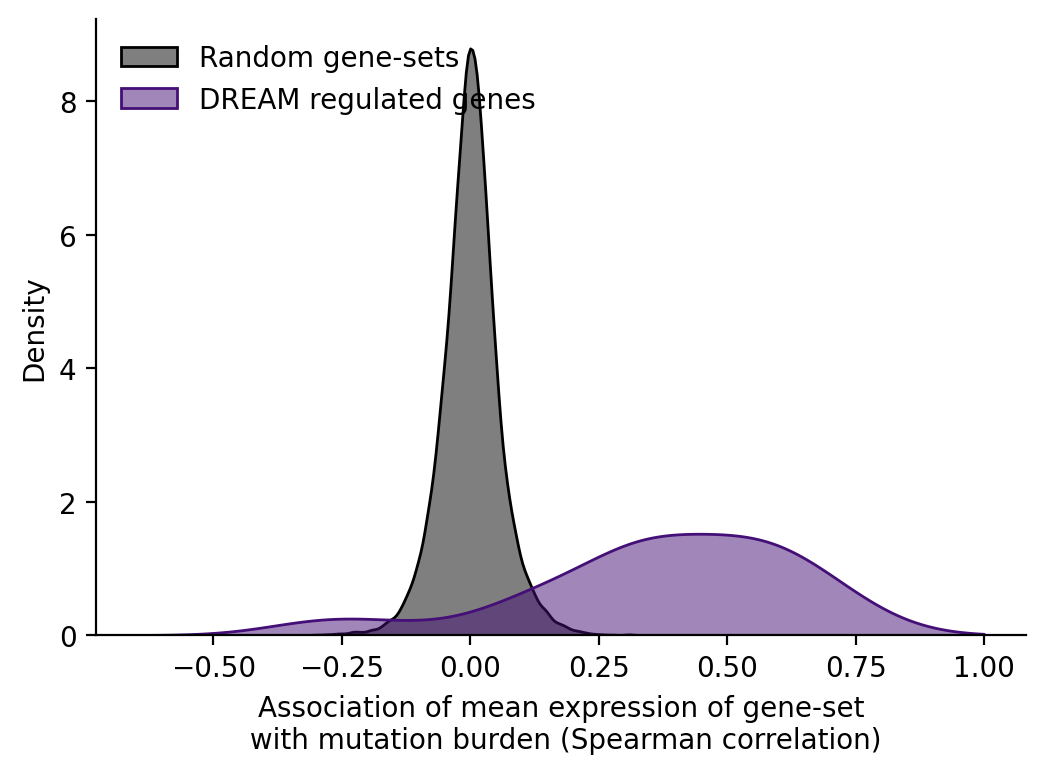

In [5]:
fig, axes = plt.subplots(figsize=(6,4))

sns.kdeplot(
    data = random_background_corr_df, hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(2), 'black'], alpha=.5, 
    ax = axes, clip = (-1,1)
    )
    
axes.set_xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
axes.legend(
    ['Random gene-sets', 'DREAM regulated genes'],
    frameon=False, loc='upper left'
    )
sns.despine()

plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/dream_vs_random_tissue_kde.svg'), format='svg', dpi=300)


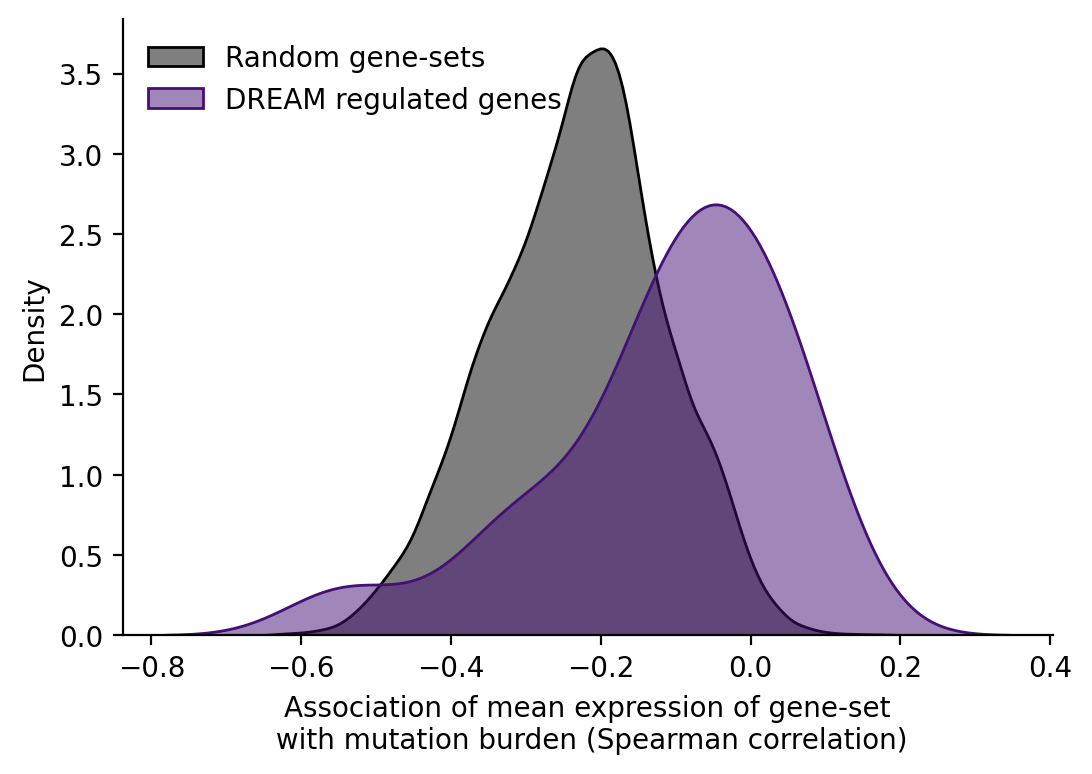

In [161]:
fig, axes = plt.subplots(figsize=(6,4))

sns.kdeplot(
    data = random_background_no_regress_corr_df, hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(2), 'black'], alpha=.5, 
    ax = axes, clip = (-1,1)
    )
    
axes.set_xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
axes.legend(
    ['Random gene-sets', 'DREAM regulated genes'],
    frameon=False, loc='upper left'
    )
sns.despine()

plt.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/dream_in_tms/dream_vs_random_tissue_kde_noregress.svg'), format='svg', dpi=300)


### Within cell types

In [6]:
# calculate correlation dfs
raw_corr_df2 = random_background.groupby(['cell_type', 'age_months']).corr(
    method='spearman', numeric_only=True
    )[mut_col].reset_index()
raw_corr_df2.rename(columns={'level_2':'variable', mut_col:'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df2['is_random_background'] = raw_corr_df2["variable"].str.contains('random')
raw_corr_df2.query("variable.str.contains('random') or variable == @dream_col", inplace=True)

corr_df = tms.dream_expression.obs.groupby(['cell_type', 'age_months'])[
    [mut_col, dream_col]
    ].corr(method = 'spearman').reset_index().iloc[::2]
corr_df.rename(columns={'level_2':'variable',dream_col:'Spearmanr'}, inplace=True)
corr_df['is_random_background'] = False
raw_corr_df2.query("variable != 'DREAM_normalized_enrichment_score_resid'", inplace=True)
random_background_corr_df_celltype = pd.concat([raw_corr_df2, corr_df])

/tmp/ipykernel_66769/2834836319.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_df = tms.dream_expression.obs.groupby(['cell_type', 'age_months'])[


In [7]:
# calculate correlation dfs
raw_corr_df_no_regress = random_background_noregress.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )[mut_col].reset_index()
raw_corr_df_no_regress.rename(columns={'level_2':'variable', mut_col:'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df_no_regress['is_random_background'] = raw_corr_df_no_regress["variable"].str.contains('random')
raw_corr_df_no_regress.query(
    "variable.str.contains('random')", 
    inplace=True
    )

corr_no_regress_df = tms.dream_expression.obs.groupby(['tissue', 'age_months'])[
    [mut_col, 'DREAM_normalized_enrichment_score']
    ].corr(method = 'spearman').reset_index().iloc[::2]
corr_no_regress_df.rename(
    columns={'level_2':'variable','DREAM_normalized_enrichment_score':'Spearmanr'}, inplace=True
    )
# flip the sign of DREAM_normalized_enrichment_score spearmans, to make direction consistent
corr_no_regress_df['Spearmanr'] = -corr_no_regress_df['Spearmanr']
corr_no_regress_df['is_random_background'] = False
random_background_no_regress_corr_df_celltype = pd.concat([raw_corr_df_no_regress, corr_no_regress_df])


/tmp/ipykernel_66769/3165575514.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_no_regress_df = tms.dream_expression.obs.groupby(['tissue', 'age_months'])[


In [ ]:
tms.dream_expression.obs

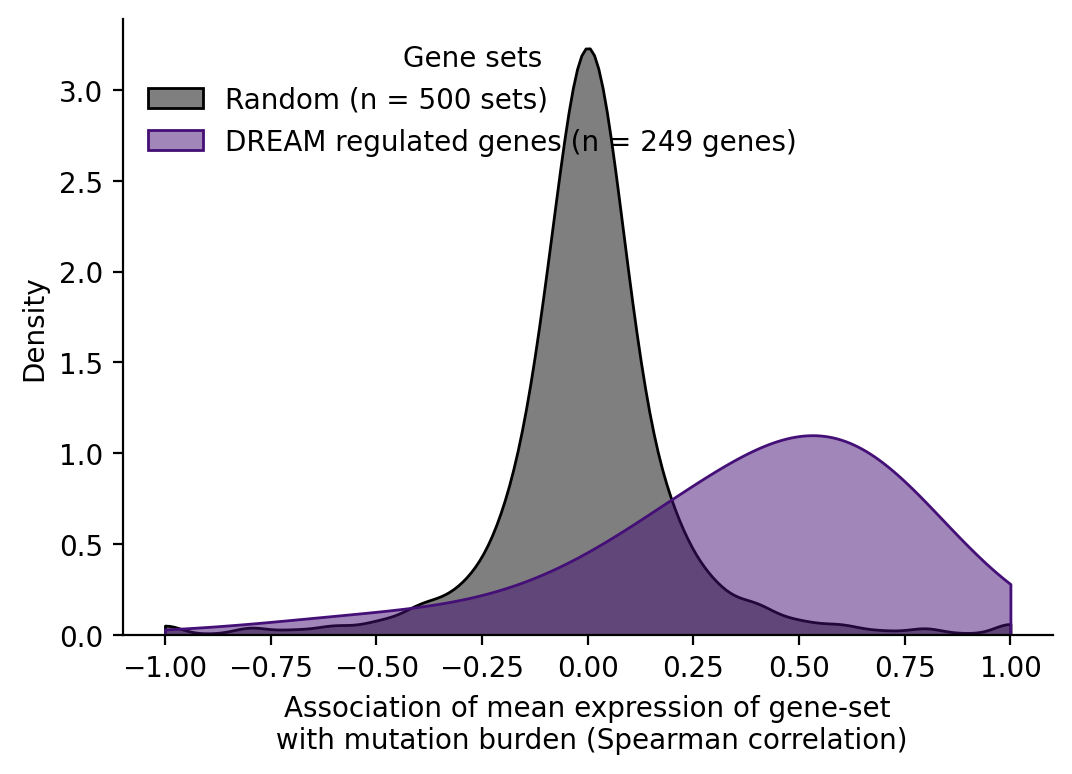

In [43]:
fig, axes = plt.subplots(figsize=(6,4))

sns.kdeplot(
    data = random_background_corr_df.query("age_months == 18"), hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(2), 'black'], alpha=.5, 
    ax = axes, clip = (-1,1),
    # increase bw
    bw_adjust= 1.6, #stat = 'density'
    )
    
axes.set_xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
axes.legend(
    ['Random (n = 500 sets)', 'DREAM regulated genes (n = 249 genes)'],
    frameon=False, loc='upper left', title='Gene sets'
    )
sns.despine()
#plt.xlim(-.95, .95)
#plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/dream_vs_random_tissue_kde.svg'), format='svg', dpi=300)


### Shared figures

In [9]:
random_background_corr_df_celltype.reset_index(inplace=True)

In [39]:
cell_types = tms.dream_expression.obs['cell_type'].value_counts()
freq_cell_types = cell_types[cell_types > 100].index

In [48]:
tms.dream_expression.obs.query("age_months == 18")['tissue'].nunique()

23

In [50]:
tms.dream_expression.obs.groupby('age_months')['mouse.id'].nunique()

age_months
3     10
18     4
21     3
24     4
Name: mouse.id, dtype: int64

MannwhitneyuResult(statistic=1036000.5, pvalue=2.5970570306512726e-36)
MannwhitneyuResult(statistic=12152.0, pvalue=4.865931634471626e-14)


Text(0.5, 0, 'Association between expression of gene-set and mutation burden (Spearman ρ)')

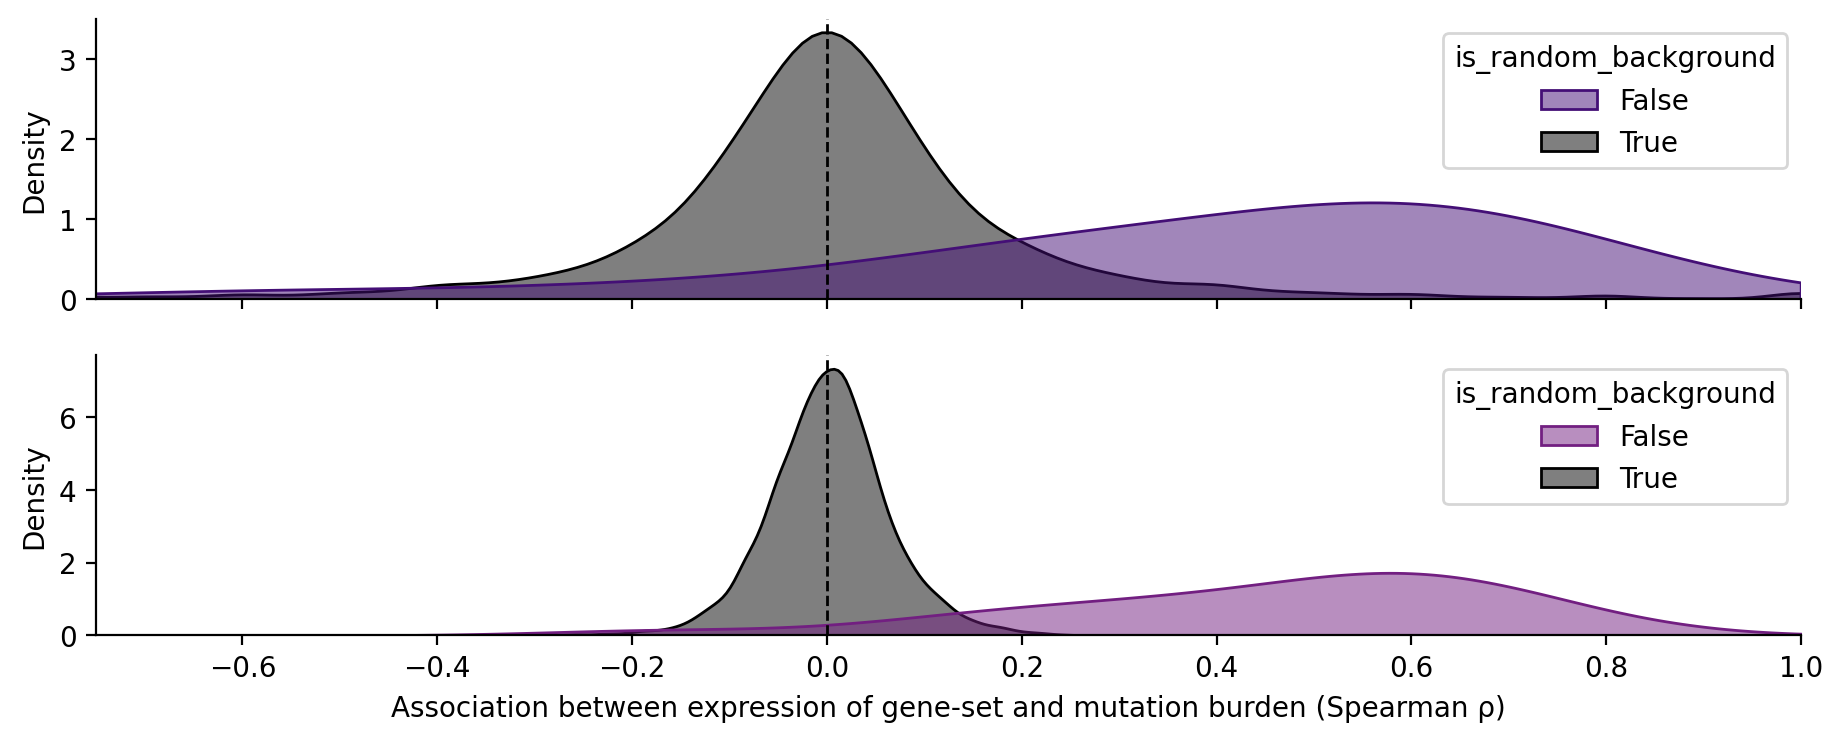

In [60]:
# yes regress
fig, axes = plt.subplots(2,1, figsize=(11,4), sharex=True, sharey=False)

cell_types = tms.dream_expression.obs['cell_type'].value_counts()
freq_cell_types = cell_types[cell_types > 100].index

# by cell type
sns.kdeplot(
    data = random_background_corr_df_celltype.query("age_months == 18"), hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(2), 'black'], alpha=.5, 
    ax = axes[0], clip = (-1,1),
    # increase bw
    bw_adjust= 1.3, 
    )
# mann whiteny u test between random and dream
print(mannwhitneyu(
    random_background_corr_df_celltype.query('age_months == 18 and is_random_background == True')['Spearmanr'].dropna(),
    random_background_corr_df_celltype.query(' age_months == 18 and is_random_background == False')['Spearmanr'].dropna()
))

# by tissue
sns.kdeplot(
    data = random_background_corr_df_tissue.query("age_months == 18"), hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(3), 'black'], alpha=.5, 
    ax = axes[1], clip = (-1,1),
    )
print(mannwhitneyu(
    random_background_corr_df_tissue.query('age_months == 18 and is_random_background == True')['Spearmanr'].dropna(),
    random_background_corr_df_tissue.query(' age_months == 18 and is_random_background == False')['Spearmanr'].dropna()
))
# draw vertical lines at 0
for ax in axes:
    ax.axvline(0, color='black', linestyle='--', lw=1)
sns.despine()
plt.xlim(-.75, 1)
plt.xlabel('Association between expression of gene-set and mutation burden (Spearman ρ)')
#plt.savefig(os.path.join(REPO_ROOT, 'figures/fig1/dream_vs_random_tissue_and_celltype_kde.svg'), format='svg', dpi=300)



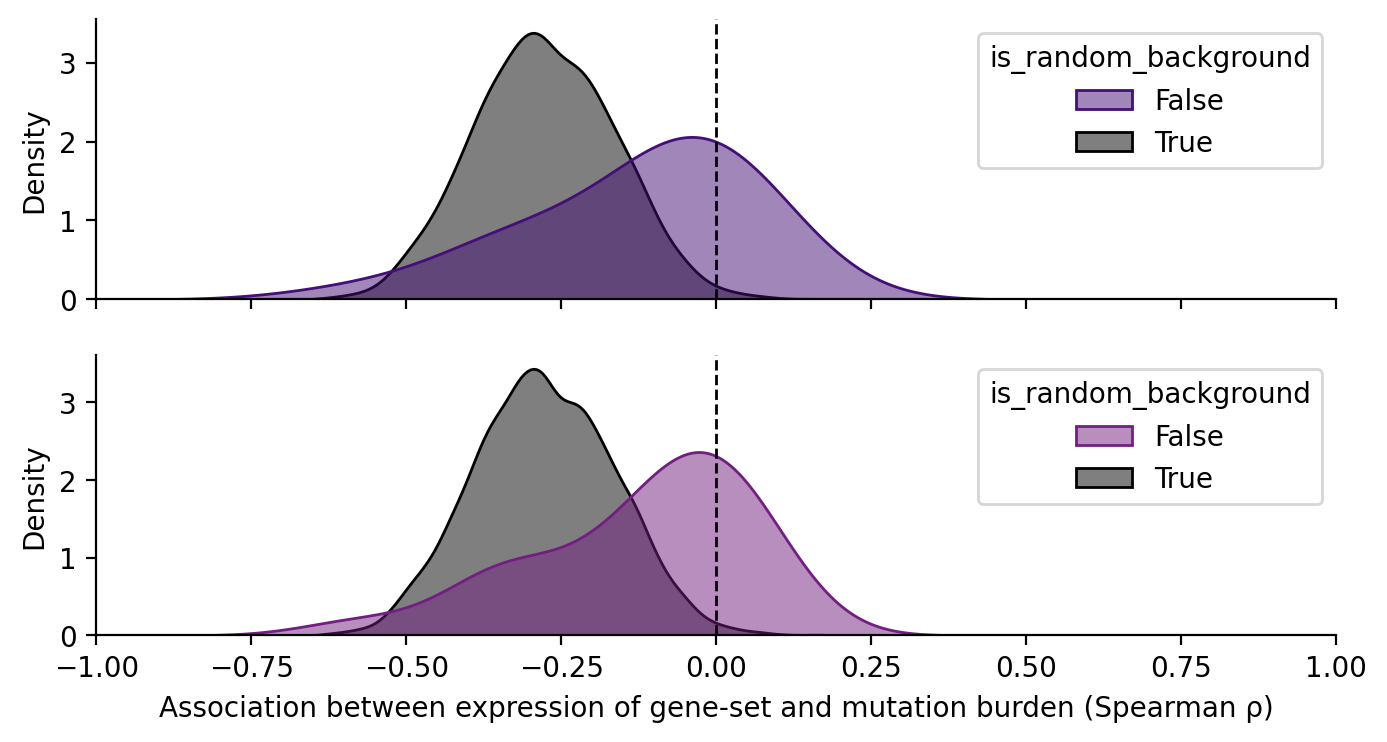

In [38]:
# no regress
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True, sharey=False)

# by cell type
sns.kdeplot(
    data = random_background_no_regress_corr_df_celltype.query("age_months == 18"), hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(2), 'black'], alpha=.5, 
    ax = axes[0], clip = (-1,1),
    # increase bw
    bw_adjust= 1.3, 
    )
# by tissue
sns.kdeplot(
    data = random_background_no_regress_corr_df_tissue.query("age_months == 18"), hue = 'is_random_background',
    x = 'Spearmanr', common_norm=False,fill=True,
    palette=[magma_categorical(3), 'black'], alpha=.5, 
    ax = axes[1], clip = (-1,1),
    )
sns.despine()
plt.xlim(-1,1)
# draw vertical lines at 0
for ax in axes:
    ax.axvline(0, color='black', linestyle='--', lw=1)
plt.xlabel('Association between expression of gene-set and mutation burden (Spearman ρ)')
plt.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/dream_in_tms/dream_vs_random_tissue_and_celltype_kde_no_regress.svg'), format='svg', dpi=300)

# Proliferation (MKI67)

Index(['ZWINT', 'RPL38', 'EME1', 'CWF19L1', 'DSCC1', 'PDE4DIP', 'FANCG',
       'RPRD2', 'WDR18', 'FNTB',
       ...
       'NCAPG2', 'RBMX', 'TTK', 'PCNA', 'AURKA', 'NIF3L1', 'KNTC1', 'SNIP1',
       'RMI1', 'SRP9'],
      dtype='object', length=249)

In [17]:
# get average MKI67 expression level by cell_type
tms.dream_expression.obs['MKI67'] = tms.adata[:, 'MKI67'].X.toarray()
tms.dream_expression.obs['PCNA'] = tms.adata[:, 'PCNA'].X.toarray()
tms.dream_expression.obs['MYC'] = tms.adata[:, 'MYC'].X.toarray()
tms.dream_expression.obs['FOXM1'] = tms.adata[:, 'FOXM1'].X.toarray()

mean_mki67_by_tissue = tms.dream_expression.obs.groupby('tissue')['MKI67'].mean()
mean_pcna_by_tissue = tms.dream_expression.obs.groupby('tissue')['PCNA'].mean()
mean_myc_by_tissue = tms.dream_expression.obs.groupby('tissue')['MYC'].mean()
mean_foxm1_by_tissue = tms.dream_expression.obs.groupby('tissue')['FOXM1'].mean()
mean_dream_activity_by_tissue = tms.dream_expression.obs.groupby('tissue')[dream_col].mean()
mean_mutation_count_by_tissue = tms.dream_expression.obs.groupby('tissue')[mut_col].mean()
# get residual of dream activity residual with respect to MKI67 expression
ols = smf.ols(
    formula=f'{dream_col} ~ MKI67 * cell_type', data=tms.dream_expression.obs
    ).fit()
tms.dream_expression.obs['dream_activity_MKI67_resid'] = ols.resid
mean_dream_activity_MKI67_resid_by_tissue = tms.dream_expression.obs.groupby('tissue')['dream_activity_MKI67_resid'].mean()

# get residual of dream activity residual with respect to PCNA expression
ols_pcna = smf.ols(
    formula=f'{dream_col} ~ PCNA * cell_type', data=tms.dream_expression.obs
    ).fit()
tms.dream_expression.obs['dream_activity_PCNA_resid'] = ols_pcna.resid
mean_dream_activity_PCNA_resid_by_tissue = tms.dream_expression.obs.groupby('tissue')['dream_activity_PCNA_resid'].mean()

# get residual of dream activity residual with respect to MYC expression
ols_myc = smf.ols(
    formula=f'{dream_col} ~ MYC * cell_type', data=tms.dream_expression.obs
    ).fit()
tms.dream_expression.obs['dream_activity_MYC_resid'] = ols_myc.resid
mean_dream_activity_MYC_resid_by_tissue = tms.dream_expression.obs.groupby('tissue')['dream_activity_MYC_resid'].mean()

# get residual of dream activity residual with respect to FOXM1 expression
ols_foxm1 = smf.ols(
    formula=f'{dream_col} ~ FOXM1 * cell_type', data=tms.dream_expression.obs
    ).fit()
tms.dream_expression.obs['dream_activity_FOXM1_resid'] = ols_foxm1.resid
mean_dream_activity_FOXM1_resid_by_tissue = tms.dream_expression.obs.groupby('tissue')['dream_activity_FOXM1_resid'].mean()




prolif_by_tissue_df = pd.DataFrame(
    {
        'MKI67': mean_mki67_by_tissue,
        'PCNA': mean_pcna_by_tissue,
        'MYC': mean_myc_by_tissue,
        'FOXM1': mean_foxm1_by_tissue,
        dream_col: mean_dream_activity_by_tissue,
        mut_col: mean_mutation_count_by_tissue,
        'dream_MKI67_resid': mean_dream_activity_MKI67_resid_by_tissue,
        'dream_PCNA_resid': mean_dream_activity_PCNA_resid_by_tissue,
        'dream_MYC_resid': mean_dream_activity_MYC_resid_by_tissue,
        'dream_FOXM1_resid': mean_dream_activity_FOXM1_resid_by_tissue
    }
    )
# get average MKI67 expression level by cell_type
# remove outlier tissues
to_remove = ["Marrow", "Large Intestine", "Tongue", "Thymus"]
mean_mki67_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['MKI67'].mean()
mean_pcna_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['PCNA'].mean()
mean_myc_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['MYC'].mean()
mean_foxm1_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['FOXM1'].mean()
mean_dream_activity_by_cell_type = tms.dream_expression.obs.groupby('cell_type')[dream_col].mean()
mean_mutation_count_by_cell_type = tms.dream_expression.obs.groupby('cell_type')[mut_col].mean()
mean_dream_activity_MKI67_resid_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['dream_activity_MKI67_resid'].mean()
mean_dream_activity_PCNA_resid_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['dream_activity_PCNA_resid'].mean()
mean_dream_activity_MYC_resid_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['dream_activity_MYC_resid'].mean()
mean_dream_activity_FOXM1_resid_by_cell_type = tms.dream_expression.obs.groupby('cell_type')['dream_activity_FOXM1_resid'].mean()

prolif_by_cell_type_df = pd.DataFrame(
    {
        'MKI67': mean_mki67_by_cell_type,
        'PCNA': mean_pcna_by_cell_type,
        'MYC': mean_myc_by_cell_type,
        'FOXM1': mean_foxm1_by_cell_type,
        dream_col: mean_dream_activity_by_cell_type,
        mut_col: mean_mutation_count_by_cell_type,
        'dream_MKI67_resid': mean_dream_activity_MKI67_resid_by_cell_type,
        'dream_PCNA_resid': mean_dream_activity_PCNA_resid_by_cell_type,
        'dream_MYC_resid': mean_dream_activity_MYC_resid_by_cell_type,
        'dream_FOXM1_resid': mean_dream_activity_FOXM1_resid_by_cell_type
    }
    )

/tmp/ipykernel_3138757/906329143.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_mki67_by_tissue = tms.dream_expression.obs.groupby('tissue')['MKI67'].mean()
/tmp/ipykernel_3138757/906329143.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pcna_by_tissue = tms.dream_expression.obs.groupby('tissue')['PCNA'].mean()
/tmp/ipykernel_3138757/906329143.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_my

<Figure size 640x480 with 0 Axes>

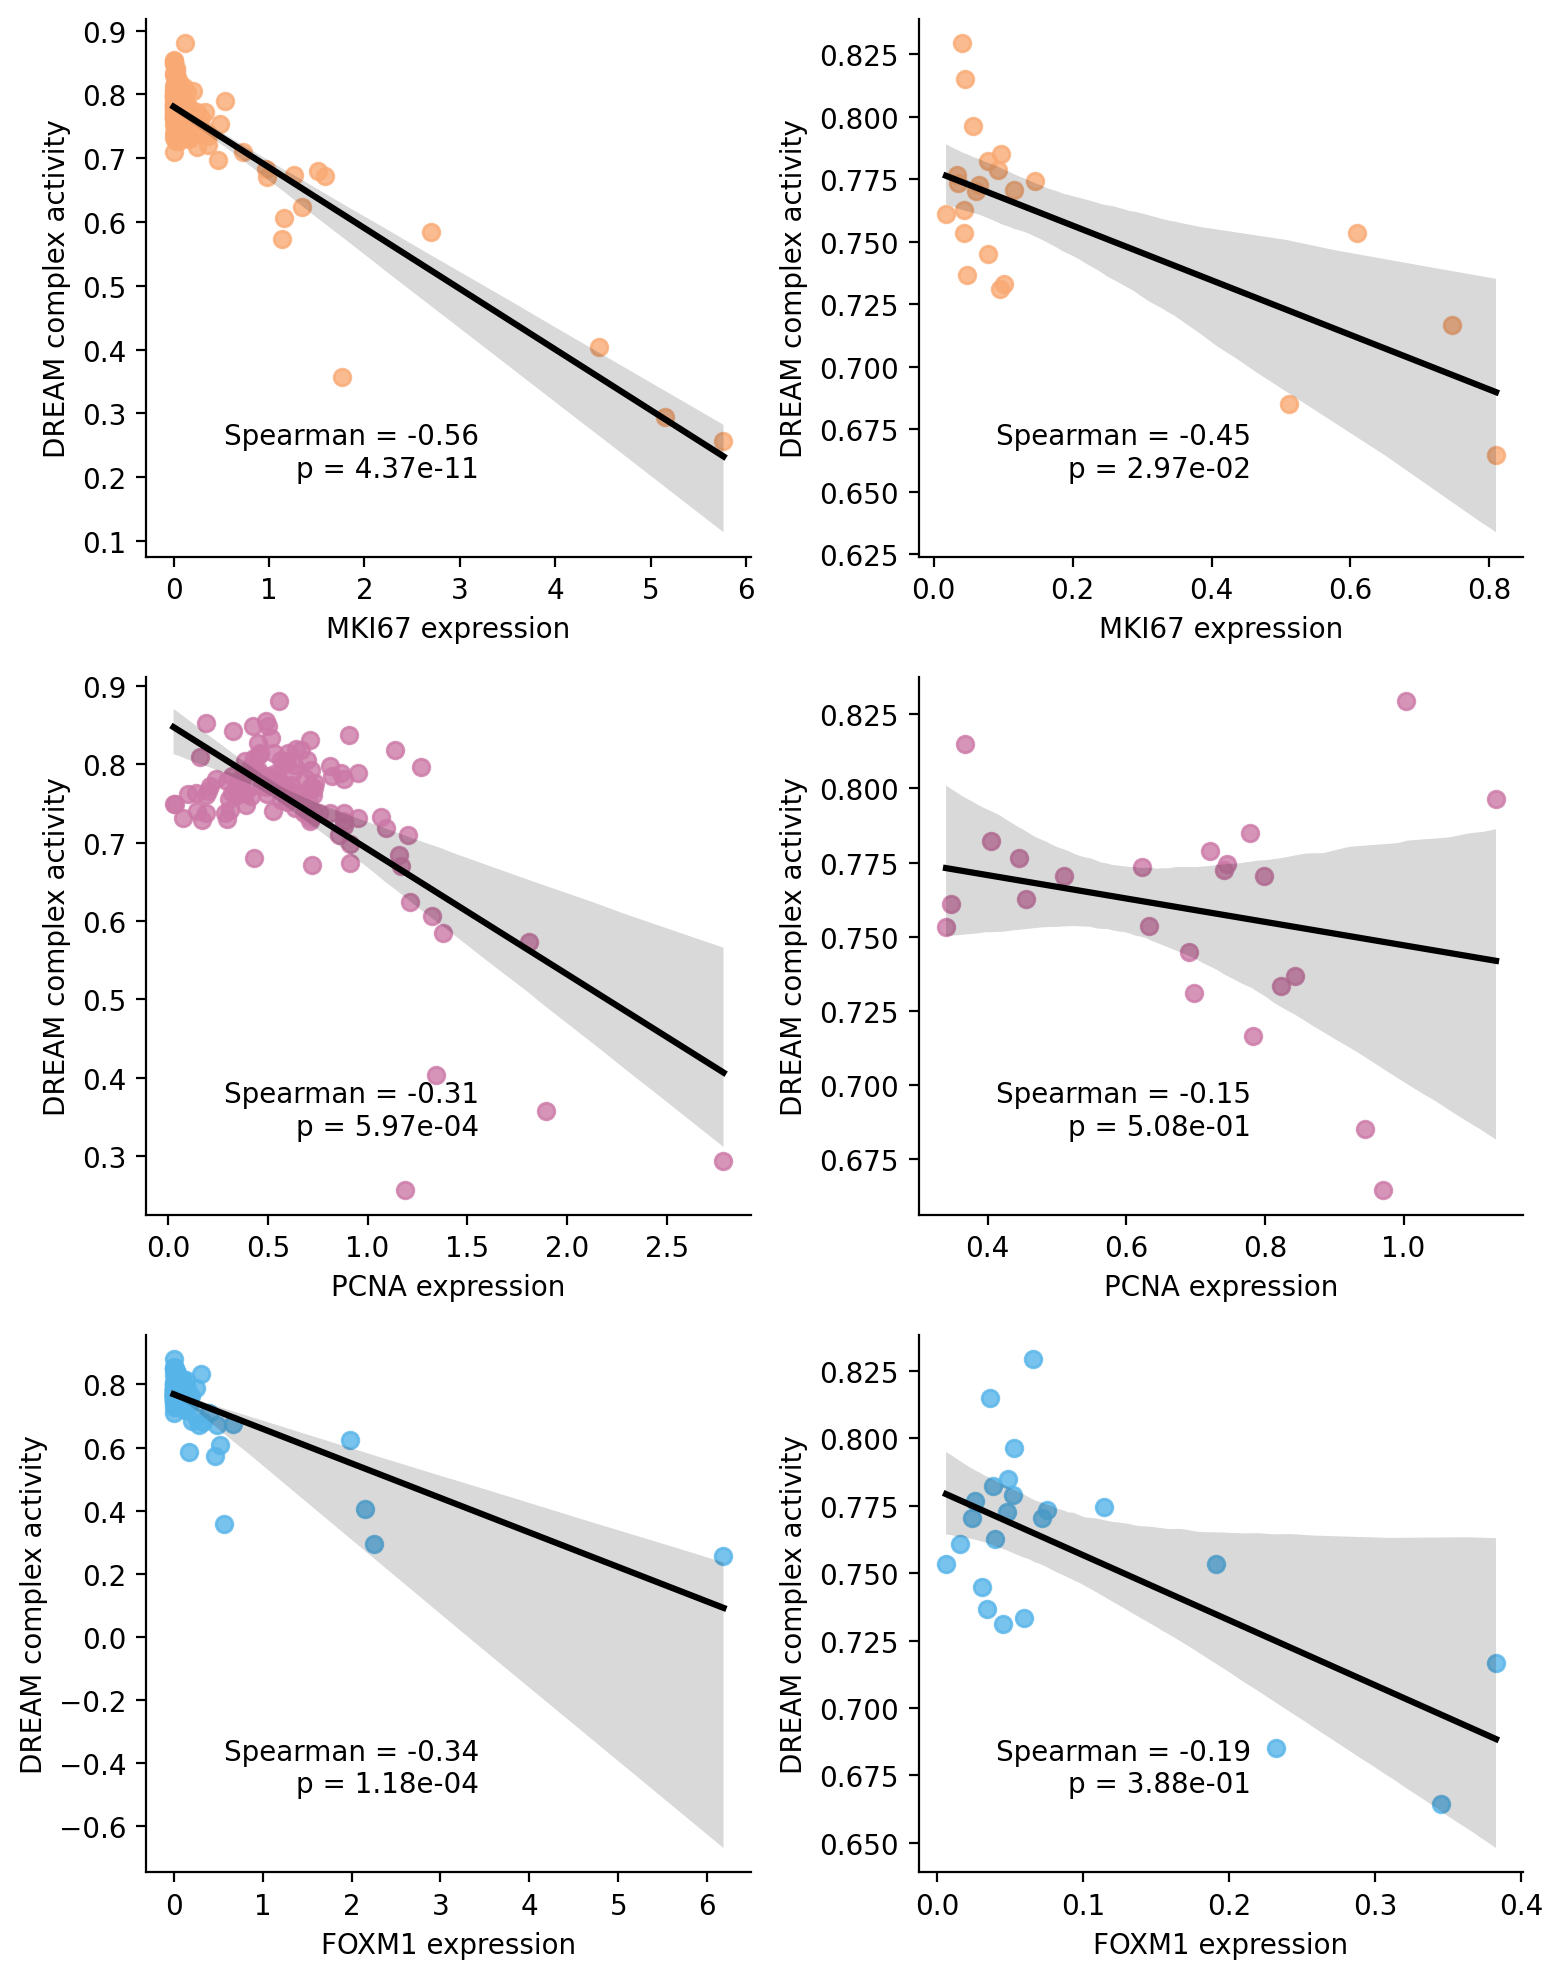

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()
# remove outlier tissues
to_remove = ["Marrow", "Large Intestine", "Tongue", "Thymus"]
#prolif_by_tissue_df.query("tissue not in @to_remove", inplace=True)

# plot MKI67 vs DREAM complex activity for cell type
sns.regplot(data=prolif_by_cell_type_df, x='MKI67', y=dream_col, ax=axes[0], color = my_categorical_palette[1], line_kws={'color':'black'})
#axes[0].set_xscale('log')
axes[0].set_ylabel('DREAM complex activity')
axes[0].set_xlabel('MKI67 expression')
r, p = spearmanr(prolif_by_cell_type_df['MKI67'], prolif_by_cell_type_df[dream_col])
axes[0].text(0.55, 0.25, f'Spearman = {r:.2f}\np = {p:.2e}', ha='right', va='top', transform=axes[0].transAxes)

# plot MKI67 vs DREAM complex activity for tissue
sns.regplot(data=prolif_by_tissue_df, x='MKI67', y=dream_col, ax=axes[1], color = my_categorical_palette[1], line_kws={'color':'black'})
#axes[4].set_xscale('log')
axes[1].set_ylabel('DREAM complex activity')
axes[1].set_xlabel('MKI67 expression')
r, p = spearmanr(prolif_by_tissue_df['MKI67'], prolif_by_tissue_df[dream_col])
axes[1].text(0.55, 0.25, f'Spearman = {r:.2f}\np = {p:.2e}', ha='right', va='top', transform=axes[1].transAxes)


# plot PCNA vs DREAM complex activity for cell type
sns.regplot(data=prolif_by_cell_type_df, x='PCNA', y=dream_col, ax=axes[2], color = my_categorical_palette[2], line_kws={'color':'black'})
axes[2].set_ylabel('DREAM complex activity')
axes[2].set_xlabel('PCNA expression')
r, p = spearmanr(prolif_by_cell_type_df['PCNA'], prolif_by_cell_type_df[dream_col])
axes[2].text(0.55, 0.25, f'Spearman = {r:.2f}\np = {p:.2e}', ha='right', va='top', transform=axes[2].transAxes)

# plot PCNA vs DREAM complex activity for tissue
sns.regplot(data=prolif_by_tissue_df, x='PCNA', y=dream_col, ax=axes[3], color = my_categorical_palette[2], line_kws={'color':'black'})
axes[3].set_ylabel('DREAM complex activity')
axes[3].set_xlabel('PCNA expression')
r, p = spearmanr(prolif_by_tissue_df['PCNA'], prolif_by_tissue_df[dream_col])
axes[3].text(0.55, 0.25, f'Spearman = {r:.2f}\np = {p:.2e}', ha='right', va='top', transform=axes[3].transAxes)


# plot FOXM1 vs DREAM complex activity for cell type
sns.regplot(data=prolif_by_cell_type_df, x='FOXM1', y=dream_col, ax=axes[4], color = my_categorical_palette[4], line_kws={'color':'black'})
axes[4].set_ylabel('DREAM complex activity')
axes[4].set_xlabel('FOXM1 expression')
r, p = spearmanr(prolif_by_cell_type_df['FOXM1'], prolif_by_cell_type_df[dream_col])
axes[4].text(0.55, 0.25, f'Spearman = {r:.2f}\np = {p:.2e}', ha='right', va='top', transform=axes[4].transAxes)

# plot FOXM1 vs DREAM complex activity for tissue
sns.regplot(data=prolif_by_tissue_df, x='FOXM1', y=dream_col, ax=axes[5], color = my_categorical_palette[4], line_kws={'color':'black'})
axes[5].set_ylabel('DREAM complex activity')
axes[5].set_xlabel('FOXM1 expression')
r, p = spearmanr(prolif_by_tissue_df['FOXM1'], prolif_by_tissue_df[dream_col])
axes[5].text(0.55, 0.25, f'Spearman = {r:.2f}\np = {p:.2e}', ha='right', va='top', transform=axes[5].transAxes)



sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/proliferation_MKI67/dream_cc_markers_scatter.svg'), format='svg', dpi=300)
plt.show()


/tmp/ipykernel_3138757/3563508033.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tp =  tms.dream_expression.obs.groupby(['cell_type', 'age_months'])[[mut_col, 'dream_activity_MKI67_resid']].corr(method = 'spearman').reset_index().iloc[::2]
/tmp/ipykernel_3138757/3563508033.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tp =  tms.dream_expression.obs.groupby(['tissue', 'age_months'])[[mut_col, 'dream_activity_MKI67_resid']].corr(method = 'spearman').reset_index().iloc[::2]


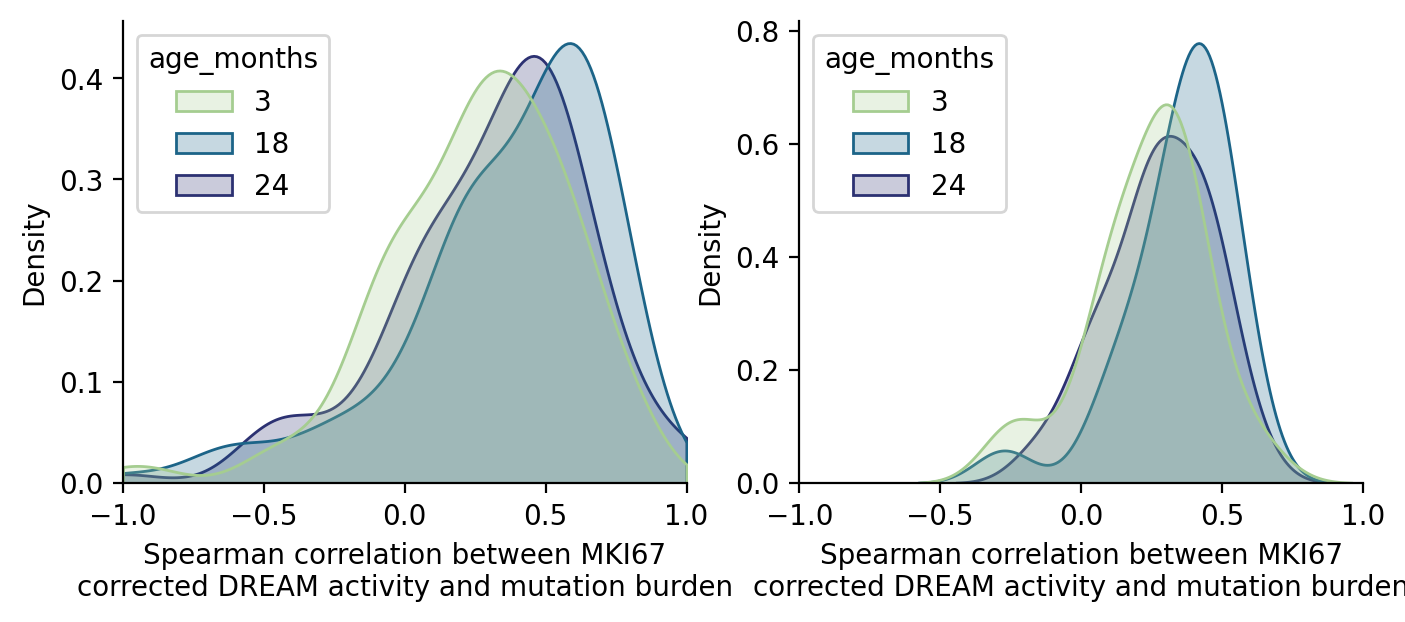

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

tp =  tms.dream_expression.obs.groupby(['cell_type', 'age_months'])[[mut_col, 'dream_activity_MKI67_resid']].corr(method = 'spearman').reset_index().iloc[::2]
# remove 24 month samples
tp.query("age_months != 21", inplace = True)
sns.kdeplot(
    data = tp,
    x = 'dream_activity_MKI67_resid', hue = 'age_months', palette='crest', fill=True, common_norm = True, clip = (-1,1), 
    ax  = axes[0],legend = 'left',
    )
axes[0].set_xlabel('Spearman correlation between MKI67\ncorrected DREAM activity and mutation burden')
axes[0].set_xlim(-1,1)



tp =  tms.dream_expression.obs.groupby(['tissue', 'age_months'])[[mut_col, 'dream_activity_MKI67_resid']].corr(method = 'spearman').reset_index().iloc[::2]
# remove 24 month samples
tp.query("age_months != 21", inplace = True)
sns.kdeplot(
    data = tp,
    x = 'dream_activity_MKI67_resid', hue = 'age_months', palette='crest', fill=True, common_norm = True, clip = (-1,1),
    legend = 'left',
    ax = axes[1]
    )
axes[1].set_xlabel('Spearman correlation between MKI67\ncorrected DREAM activity and mutation burden')
axes[1].set_xlim(-1,1)

sns.despine()
plt.show()
plt.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/proliferation_MKI67/corrected_for_MKI67.svg'), format='svg', dpi=300)



# Stats for text

In [15]:
smf.ols(
    formula=f'{mut_col} ~ age_months + 0', data=tms.dream_expression.obs.query("tissue == 'Kidney' and age_months != 21")
    ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     mutation_count_per_kb_top50expr   R-squared (uncentered):                   0.763
Model:                                         OLS   Adj. R-squared (uncentered):              0.763
Method:                              Least Squares   F-statistic:                              5910.
Date:                             Wed, 26 Jun 2024   Prob (F-statistic):                        0.00
Time:                                     15:49:04   Log-Likelihood:                          3079.9
No. Observations:                             1833   AIC:                                     -6158.
Df Residuals:                                 1832   BIC:                                     -6152.
Df Model:                                        1                                                  
Covariance Type:                         nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_months     0.0045   5.81e-05     76.875      0.000       0.004       0.005
==============================================================================
Omnibus:                        9.468   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                7.312
Skew:                           0.046   Prob(JB):                       0.0258
Kurtosis:                       2.704   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
smf.ols(
    formula=f'{mut_col} ~ age_months + 0', data=tms.dream_expression.obs.query("tissue == 'Skin' and age_months != 21")
    ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     mutation_count_per_kb_top50expr   R-squared (uncentered):                   0.690
Model:                                         OLS   Adj. R-squared (uncentered):              0.690
Method:                              Least Squares   F-statistic:                          1.080e+04
Date:                             Wed, 26 Jun 2024   Prob (F-statistic):                        0.00
Time:                                     15:51:35   Log-Likelihood:                          10078.
No. Observations:                             4860   AIC:                                 -2.015e+04
Df Residuals:                                 4859   BIC:                                 -2.015e+04
Df Model:                                        1                                                  
Covariance Type:                         nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_months     0.0030   2.88e-05    103.933      0.000       0.003       0.003
==============================================================================
Omnibus:                      237.404   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.168
Skew:                          -0.574   Prob(JB):                     7.93e-60
Kurtosis:                       3.164   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Distrbution by mouse and tissue

/tmp/ipykernel_2106555/3870994907.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tissue_order = to_plot.groupby('tissue')[dream_col].quantile(0.75).sort_values(ascending=False).index
/tmp/ipykernel_2106555/3870994907.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=to_plot, x='tissue', y=dream_col,
/tmp/ipykernel_2106555/3870994907.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2106555/3870994907.py:18: FutureWarning: The default of observed=False is deprec

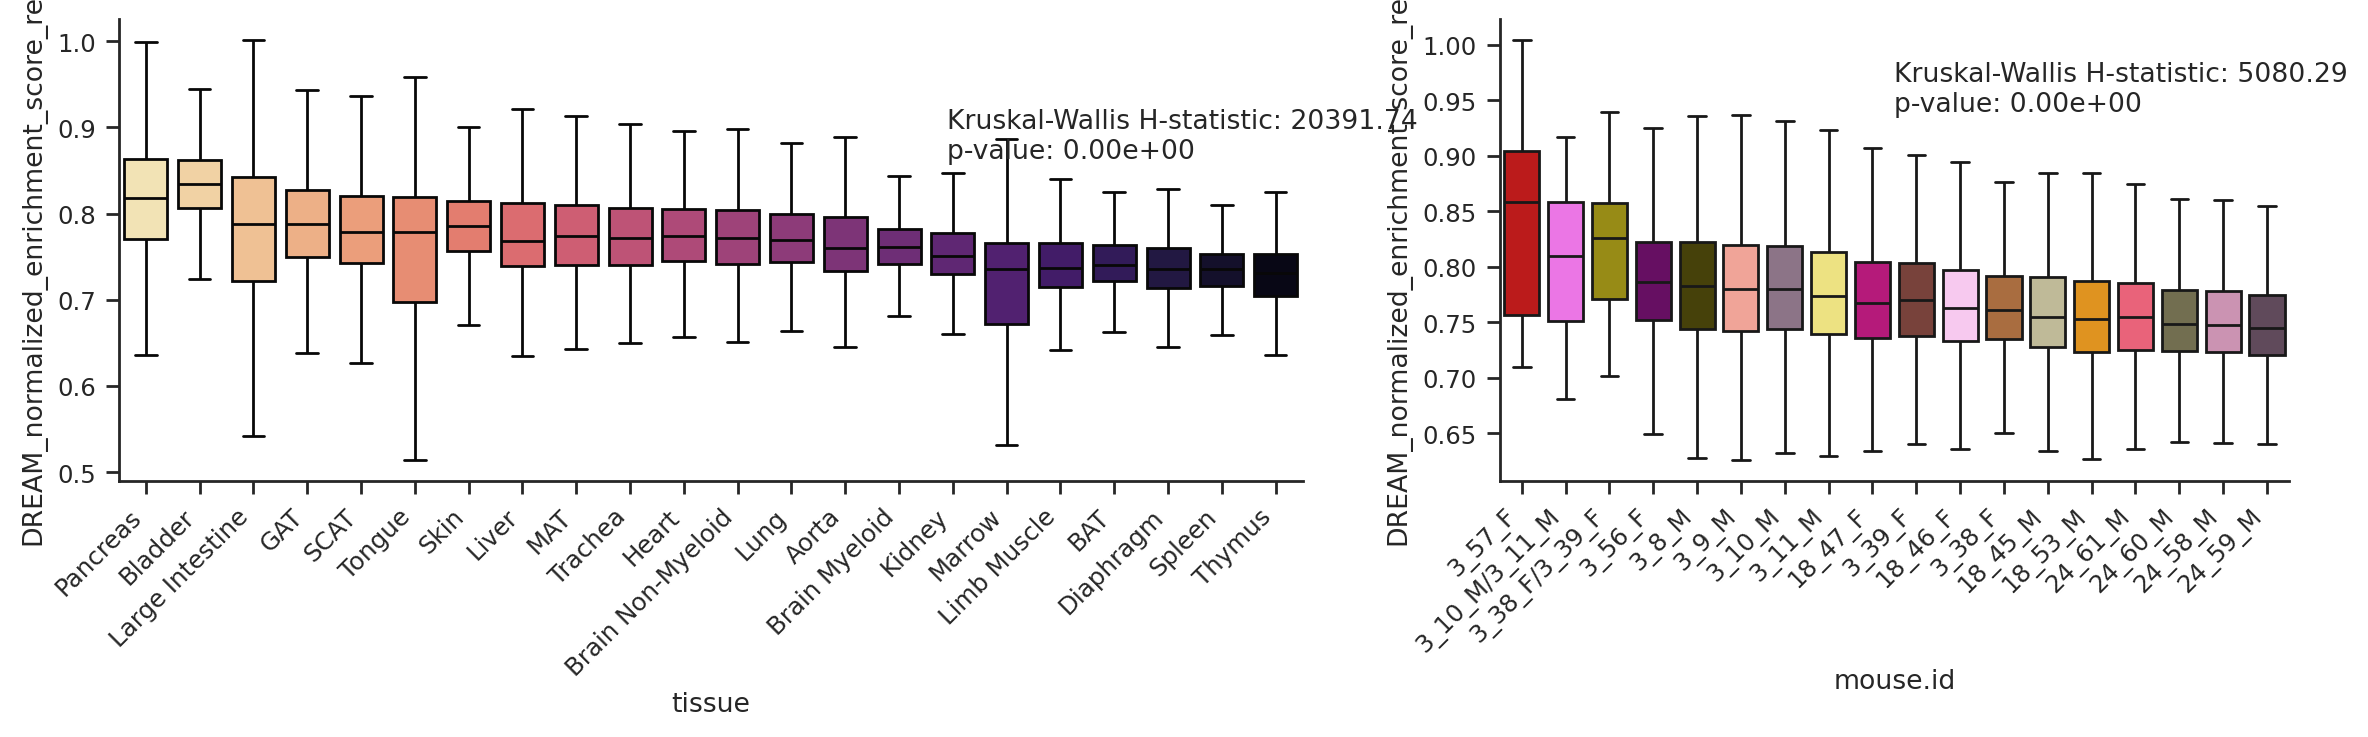

In [48]:
fig, axes = plt.subplots(1,2, figsize=(14,3), gridspec_kw={'width_ratios': [1.5, 1]})

to_plot = tms.dream_expression.obs.query("age_months != 21 and tissue != 'Mammary Gland'").copy(deep=True)
# remove unused categories
to_plot['tissue'] = to_plot['tissue'].cat.remove_unused_categories()
to_plot['mouse.id'] = to_plot['mouse.id'].cat.remove_unused_categories()


to_plot['mouse.id'] = pd.Categorical(to_plot['mouse.id'])
tissue_order = to_plot.groupby('tissue')[dream_col].quantile(0.75).sort_values(ascending=False).index
# plot distribution of DREAM_normalized_enrichment_score by tissue
sns.boxplot(data=to_plot, x='tissue', y=dream_col, 
            showfliers=False, palette='magma_r', ax=axes[0], order=tissue_order)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# perform kruskal-wallis test between tissues
h_stat, p_val = stats.kruskal(*[group[dream_col].dropna().values 
                               for name, group in to_plot.groupby('tissue')])

# add test statistics to plot
axes[0].text(0.7, .7, f'Kruskal-Wallis H-statistic: {h_stat:.2f}\np-value: {p_val:.2e}', 
             transform=axes[0].transAxes)


# get 75th percentile for each mouse.id
mouse_order = to_plot.groupby('mouse.id')[dream_col].quantile(0.75).sort_values(ascending=False).index
# set order of mouse.id
to_plot['mouse.id'] = pd.Categorical(to_plot['mouse.id'], categories=mouse_order)
# use glasbey from colorcet
sns.boxplot(data = to_plot, x = 'mouse.id', y = dream_col, showfliers = False, order = mouse_order, palette=cc.glasbey_warm, ax=axes[1])
# perform kruskal-wallis test to check if there are differences between mice
from scipy import stats
# run kruskal-wallis test
h_stat, p_val = stats.kruskal(*[group[dream_col].values 
                               for name, group in to_plot.groupby('mouse.id')])

# add to plot
axes[1].text(0.5, .8, f'Kruskal-Wallis H-statistic: {h_stat:.2f}\np-value: {p_val:.2e}', transform=axes[1].transAxes)

axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha='right')
sns.despine()
fig.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/dream_in_tms/dream_by_mouse_and_tissue_boxplots.svg'), format='svg', dpi=300)

# Distribution by age of mouse

/tmp/ipykernel_2637408/3258943324.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  burden_order = copy.groupby(['tissue', 'age_months'])[mut_col].median().sort_values(ascending=False).reset_index().query('age_months == 24')['tissue']


Bladder SignificanceResult(statistic=np.float64(-0.23706509856722335), pvalue=np.float64(2.0441872809193847e-32))
Diaphragm SignificanceResult(statistic=np.float64(-0.2564439255363774), pvalue=np.float64(2.7497006782837383e-29))
Spleen SignificanceResult(statistic=np.float64(0.012258719827503373), pvalue=np.float64(0.4479528340435174))
Kidney SignificanceResult(statistic=np.float64(-0.12249706862543985), pvalue=np.float64(1.4344568696589666e-07))
Limb Muscle SignificanceResult(statistic=np.float64(-0.38328454863695727), pvalue=np.float64(3.8843462034172e-135))
Large Intestine SignificanceResult(statistic=np.float64(-0.033094284227065465), pvalue=np.float64(0.002549508785177702))
BAT SignificanceResult(statistic=np.float64(-0.12478087809865863), pvalue=np.float64(3.568825020019888e-09))
Aorta SignificanceResult(statistic=np.float64(-0.2228331809655035), pvalue=np.float64(1.17339173397986e-11))
Trachea SignificanceResult(statistic=np.float64(-0.32679264159970306), pvalue=np.float64(1.548

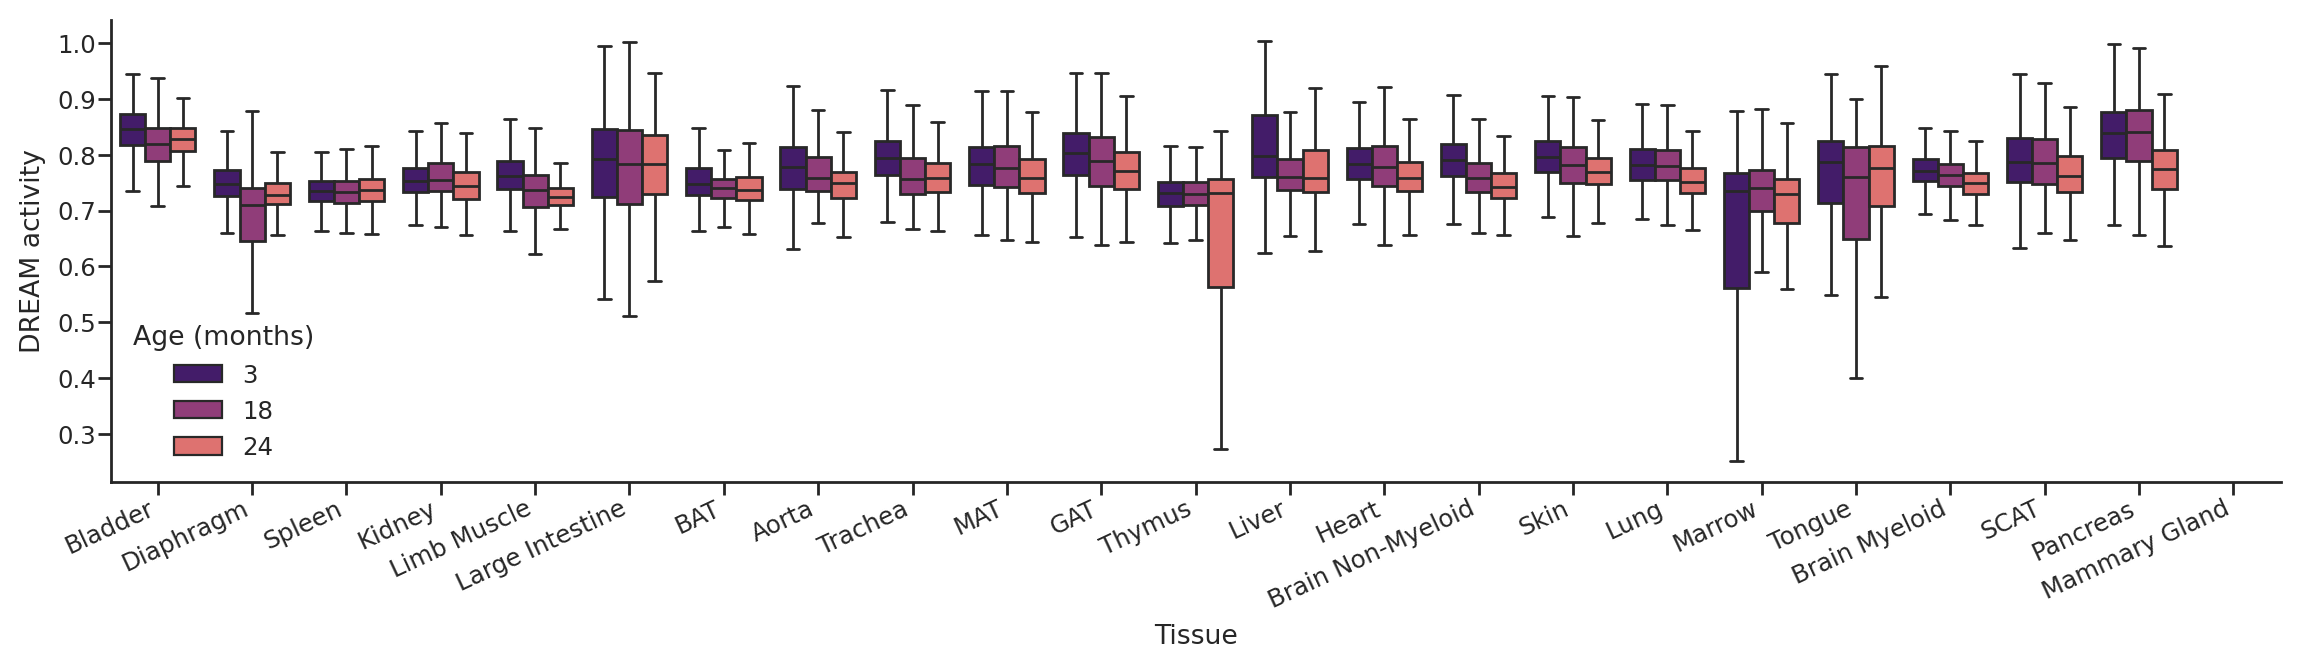

In [17]:
copy = tms.dream_expression.obs.query("age_months != 21 and tissue != 'Mammary Gland'").copy()
fig, axes = plt.subplots(figsize=(14,3))
# within each age, bin the mean_dream_activity into 3 bins
burden_order = copy.groupby(['tissue', 'age_months'])[mut_col].median().sort_values(ascending=False).reset_index().query('age_months == 24')['tissue']
sns.boxplot(
    data = copy, y = dream_col, x = 'tissue',
    hue = 'age_months', palette=[magma_categorical(2), magma_categorical(4), magma_categorical(6)], showfliers = False,
    ax = axes, order = burden_order, hue_order=[3, 18, 24]
    )
# angle x labels
axes.tick_params(pad=.5)
_ = plt.xticks(rotation=25, ha='right')
plt.xlabel('Tissue')
plt.ylabel('DREAM activity')
# remove legend border
plt.legend(title='Age (months)', frameon=False)
sns.despine()
# print is there is significant negative association between dream activity and age for each tissue
for tissue in burden_order:
    print(tissue, spearmanr(copy.loc[copy['tissue'] == tissue, 'age_months'], copy.loc[copy['tissue'] == tissue, 'DREAM_normalized_enrichment_score_resid']))

fig.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/dream_in_tms/dream_by_tissue_and_age_boxplots.svg'), format='svg', dpi=300)